## <span style="color:green"><h1><center>Part 1: CAMELS-Like Data Preparation for USGS Basins – Catchment Attributes</center></h1></span>
<center>Prepared by <br>
<b>Mohammad Galib and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
mgalib@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>
    
---

## <span style="color:green">Table of Contents</span>

1. [Introduction and Objectives](#1-introduction-and-objectives)  
2. [Understanding CAMELS: Background and Significance](#2-understanding-camels-background-and-significance)  
3. [Tutorial Setup and Dependencies](#3-tutorial-setup-and-dependencies)  
4. [Watershed Delineation](#4-watershed-delineation)  
5. [Topographic Attributes](#5-topographic-attributes)  
6. [Climatic Indices](#6-climatic-indices)  
7. [Soil Characteristics](#7-soil-characteristics)  
8. [Vegetation Characteristics](#8-vegetation-characteristics)  
9. [Geological Characteristics](#9-geological-characteristics)  
10. [Hydrological Signatures](#10-hydrological-signatures)  
11. [Data Integration and Export](#11-data-integration-and-export)  
12. [Results Validation](#12-results-validation)  
13. [Extending to Multiple Basins](#13-extending-to-multiple-basins)  
14. [Summary](#14-summary)  


## <span style="color:green">1. Introduction and Objectives</span>

### <span style="color:green">Learning Objectives</span>
<p style='text-align: justify;'>
By the end of this tutorial, you will be able to:
</p>

- Extract and process catchment-scale attributes for any USGS basin in the United States  
- Understand the hydrological significance of each attribute class  
- Create a reproducible workflow for large-sample hydrology studies  
- Generate datasets compatible with machine learning and comparative hydrology applications  

### <span style="color:green">What You'll Build</span>
<p style='text-align: justify;'>
A comprehensive dataset containing:
</p>

- <b>Topographic attributes</b> (elevation, slope, area)  
- <b>Climatic indices</b> (precipitation, temperature patterns, seasonality)  
- <b>Soil properties</b> (depth, porosity, water storage capacity)  
- <b>Vegetation characteristics</b> (land cover, LAI, root depth)  
- <b>Geological features</b> (lithology, permeability)  
- <b>Hydrological signatures</b> (flow statistics, event characteristics)  


## <span style="color:green">2. Understanding CAMELS: Background and Significance</span>

### <span style="color:green">What is CAMELS?</span>
<p style='text-align: justify;'>
CAMELS (Catchment Attributes and Meteorology for Large-sample Studies) is a foundational dataset in hydrology that provides standardized attributes for 671 watersheds across the contiguous United States. Originally developed by Newman et al. (2015) and Addor et al. (2017), CAMELS has become the gold standard for large-sample hydrological studies.
</p>

### <span style="color:green">Why CAMELS-like Datasets Matter</span>

**For Hydrological Understanding**
- Enable comparative analysis across different climatic and physiographic regions  
- Support process-based understanding of catchment behavior  
- Facilitate identification of dominant controls on hydrological response  

**For Machine Learning Applications**
- Provide standardized input features for predictive modeling  
- Enable transfer learning between different catchments  
- Support uncertainty quantification in hydrological predictions  


## <span style="color:green">3. Tutorial Setup and Dependencies</span>

### <span style="color:green">Required Libraries</span>
<p style='text-align: justify;'>
This tutorial relies on Python libraries for geospatial analysis, hydrological data access, and scientific computing. Before running the code cells, make sure you have installed all required dependencies in your environment.
</p>



In [1]:
# Core libraries
import json
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from typing import Union
warnings.filterwarnings('ignore')

# Geospatial and hydrological libraries
from pynhd import NLDI
from streamstats import Watershed
import py3dep
import xrspatial
import pygridmet as gridmet
import hydrofunctions as hf
#from pydaymet import get_bycoords
import pygeohydro as gh
from pygeohydro import NWIS, soil_properties, soil_polaris
from pygeoutils import xarray_geomask
from pygeoglim import glim_attributes, glhymps_attributes

# Remote sensing and cloud platforms
from pystac_client import Client
import planetary_computer
import rioxarray
import rasterio
from rasterio.mask import mask

# Statistical and curve fitting
from scipy.optimize import curve_fit
from functools import reduce

print("All required libraries loaded successfully!")
%matplotlib inline


All required libraries loaded successfully!


### <span style="color:green">Environment Setup</span>

In [2]:
# Configuration
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)  # For reproducibility

# Create output directories
import os
os.makedirs('outputs/plots', exist_ok=True)
os.makedirs('outputs/data', exist_ok=True)
os.makedirs('outputs/shapefiles', exist_ok=True)

## <span style="color:green">4. Watershed Delineation</span>

### <span style="color:green">Learning Objectives</span>
- Understand watershed delineation principles  
- Learn to use automated delineation tools  
- Validate watershed boundaries  

### <span style="color:green">Hydrological Background</span>
<p style='text-align:justify;'>
Watershed delineation is the foundation of catchment-scale analysis. The watershed boundary defines the area that contributes surface water flow to a specific outlet point (USGS gauge). Accurate delineation ensures that all computed attributes represent the actual contributing area. It leverages web services such as <b>USGS NLDI</b> to automatically retrieve standardized watershed geometries, ensuring reproducibility across studies.
</p>

### <span style="color:green">Gauge Selection</span>


In [3]:
def get_user_input():
    """Interactive function to get USGS gauge ID from user"""
    while True:
        gauge_id = input("Enter USGS gauge ID (e.g., 01031500, 03291780): ").strip()
        if len(gauge_id) >= 8 and gauge_id.isdigit():
            return gauge_id
        else:
            print("Please enter a valid 8+ digit USGS gauge ID")

# Get gauge ID from user
gauge_id = get_user_input()
print(f"Processing gauge: {gauge_id}")

Enter USGS gauge ID (e.g., 01031500, 03291780):   01031500


Processing gauge: 01031500


Delineating watershed for gauge 01031500...
✓ Saved shapefile: outputs/shapefiles/watershed_01031500.shp
✓ Successfully delineated watershed
  Gauge Name: Piscataquis River Near Dover-Foxcroft, Maine
  Area: 774.15 km²
  HUC02: 01
  Location: (45.175, -69.315)


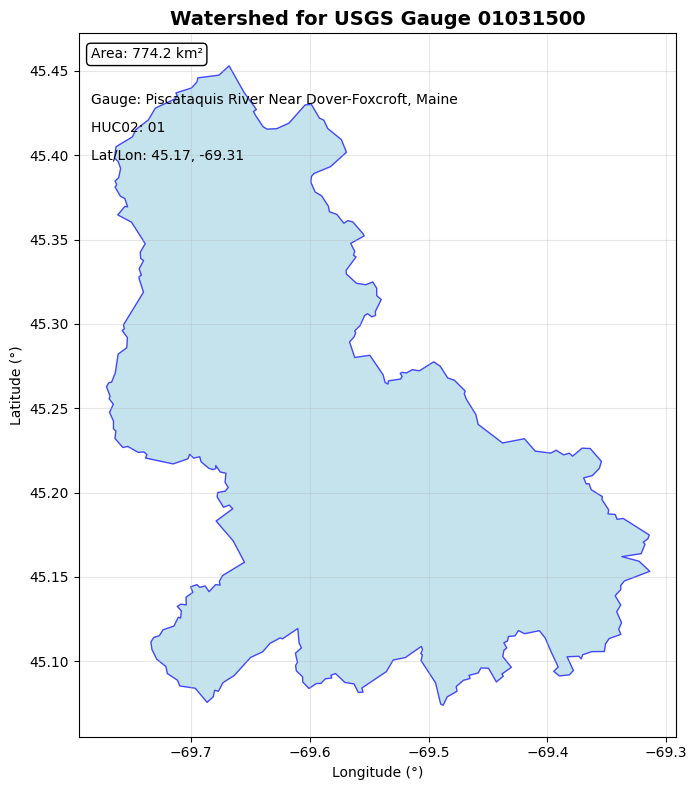


Metadata:
{'gauge_id': '01031500', 'gauge_name': 'Piscataquis River Near Dover-Foxcroft, Maine', 'gauge_lat': 45.175, 'gauge_lon': -69.3147222, 'huc_02': '01', 'geometry': <POLYGON ((-69.398 45.107, -69.402 45.114, -69.407 45.118, -69.42 45.117, -6...>}


In [31]:
def delineate_watershed(gauge_id, save_shapefile=True):
    """
    Delineate watershed boundary for a given USGS gauge, 
    fetch metadata (name, lat, lon, HUC02), and plot results.
    
    Parameters
    ----------
    gauge_id : str
        USGS gauge identifier
    save_shapefile : bool
        Whether to save the watershed boundary as shapefile
    
    Returns
    -------
    tuple
        (watershed_gdf, watershed_geom, metadata_dict)
    """
    try:
        print(f"Delineating watershed for gauge {gauge_id}...")

        # --- Delineate watershed ---
        nldi = NLDI()
        watershed_gdf = nldi.get_basins(gauge_id)

        # Ensure CRS is WGS84
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")

        watershed_geom = watershed_gdf.geometry.iloc[0]

        # Calculate area
        area_km2 = watershed_gdf.to_crs("EPSG:5070").geometry.area.iloc[0] / 1e6

        # Save shapefile if requested
        if save_shapefile:
            shapefile_path = f"outputs/shapefiles/watershed_{gauge_id}.shp"
            watershed_gdf.to_file(shapefile_path)
            print(f"✓ Saved shapefile: {shapefile_path}")

        # --- Fetch gauge metadata ---
        nwis = NWIS()
        site_info = nwis.get_info([{"site": gauge_id}])
        site_info["site_no"] = site_info["site_no"].astype(str)
        row = site_info.loc[site_info["site_no"] == str(gauge_id)].iloc[0]

        gauge_lat = float(row["dec_lat_va"])
        gauge_lon = float(row["dec_long_va"])
        gauge_name = row["station_nm"]

        huc_full = str(row.get("huc_cd", ""))
        huc_02 = huc_full[:2] if len(huc_full) >= 2 else "NA"

        metadata = {
            "gauge_id": str(gauge_id),
            "gauge_name": gauge_name,
            "gauge_lat": gauge_lat,
            "gauge_lon": gauge_lon,
            "huc_02": huc_02,
            "geometry": watershed_geom
        }

        print(f"✓ Successfully delineated watershed")
        print(f"  Gauge Name: {gauge_name}")
        print(f"  Area: {area_km2:.2f} km²")
        print(f"  HUC02: {huc_02}")
        print(f"  Location: ({gauge_lat:.3f}, {gauge_lon:.3f})")

        # --- Plot watershed with metadata ---
        fig, ax = plt.subplots(figsize=(10, 8))
        watershed_gdf.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.7)

        ax.set_title(f"Watershed for USGS Gauge {gauge_id}", fontsize=14, fontweight="bold")
        ax.set_xlabel("Longitude (°)")
        ax.set_ylabel("Latitude (°)")
        ax.grid(True, alpha=0.3)

        # Area annotation
        ax.text(0.02, 0.98, f"Area: {area_km2:.1f} km²",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white"),
                verticalalignment="top")

        # Metadata annotations
        ax.text(0.02, 0.90, f"Gauge: {gauge_name}", transform=ax.transAxes, fontsize=10, ha="left")
        ax.text(0.02, 0.86, f"HUC02: {huc_02}", transform=ax.transAxes, fontsize=10, ha="left")
        ax.text(0.02, 0.82, f"Lat/Lon: {gauge_lat:.2f}, {gauge_lon:.2f}",
                transform=ax.transAxes, fontsize=10, ha="left")

        plt.tight_layout()
        plt.savefig(f"outputs/plots/watershed_{gauge_id}.png", dpi=300, bbox_inches="tight")
        plt.show()

        return watershed_gdf, watershed_geom, metadata, area_km2

    except Exception as e:
        print(f"✗ Error delineating watershed: {str(e)}")
        return None, None, None


# === Delineate ===
watershed_gdf, watershed_geom, metadata, area_km2 = delineate_watershed(gauge_id)

print("\nMetadata:")
print(metadata)


## <span style="color:green">5. Topographic Attributes</span>

### <span style="color:green">Learning Objectives</span>
- Understand how topography controls hydrological processes  
- Extract elevation and slope statistics from DEM data  
- Compute drainage area accurately  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Topographic attributes are fundamental controls on hydrological processes. 
<b>Elevation</b> regulates temperature gradients, precipitation patterns, and snow accumulation/melt. 
<b>Slope</b> influences runoff velocity, infiltration capacity, and erosion potential. 
<b>Drainage area</b> defines the contributing surface area that generates flow toward the outlet. 
By combining these attributes, we can characterize the geomorphological setting of a watershed in a way that is both physically meaningful and consistent with CAMELS conventions.
</p>

### <span style="color:green">Topographic Analysis Functions</span>
<p style='text-align: justify;'>
In this step, we use the <b>USGS 3DEP DEM</b> dataset to extract elevation and slope information for the watershed. 
We calculate mean, minimum, maximum, and variability of elevation and slope, along with the catchment drainage area. 
The results replicate the <b>camels_topo</b> attributes from CAMELS and provide essential descriptors for hydrological modeling and comparative basin analysis.
</p>


Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.00, max=101.46, mean=8.45
✓ Topographic attributes extracted successfully

Topographic Attributes (with units):
  elev_mean: 301.912 m
  elev_min: 109.704 m
  elev_max: 798.635 m
  elev_std: 106.893 m
  slope_mean: 8.448 %
  slope_std: 7.227 %
  area_geospa_fabric: 774.154 km²


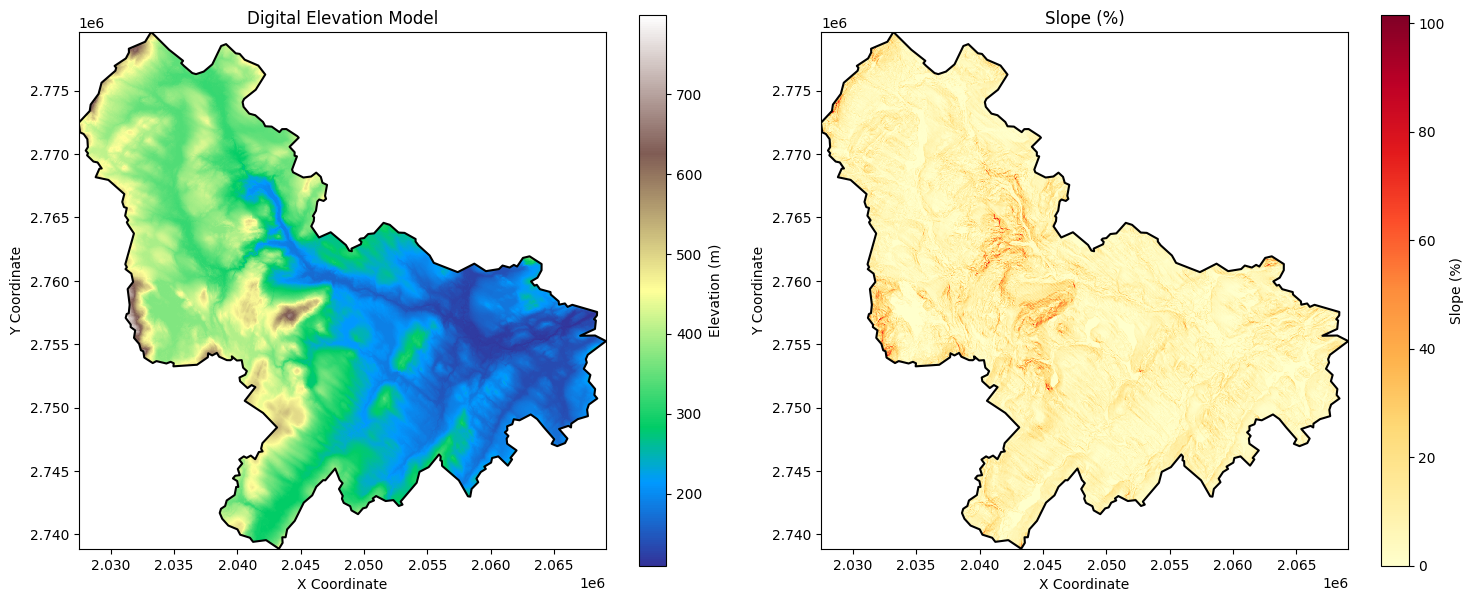

In [5]:
def extract_topographic_attributes(watershed_geom, resolution=30):
    """
    Extract topographic attributes from DEM data, aligned with CAMELS conventions.
    
    Parameters
    ----------
    watershed_geom : shapely.geometry
        Watershed boundary geometry
    resolution : int
        DEM resolution in meters (default: 30m from 3DEP)
        
    Returns
    -------
    dict : Topographic attributes (keys without units)
    dict : Units for each attribute
    xarray.DataArray : DEM
    xarray.DataArray : Slope (%)
    """
    try:
        print("Extracting topographic attributes...")
        
        # --- DEM ---
        print("  - Downloading DEM data...")
        dem = py3dep.get_dem(watershed_geom, resolution=resolution)
        dem_proj = dem.rio.reproject("EPSG:5070")  # Equal-area projection
        
        # --- Slope ---
        print("  - Computing slope...")
        slope_deg = xrspatial.slope(dem_proj)        # slope in degrees
        slope_mpm = py3dep.deg2mpm(slope_deg)        # slope in m/m
        slope_pct = slope_mpm * 100                  # percent (CAMELS convention)
        
        print("  - Slope stats (%):")
        print(f"    min={float(slope_pct.min().values):.2f}, "
              f"max={float(slope_pct.max().values):.2f}, "
              f"mean={float(slope_pct.mean().values):.2f}")
        
        # --- Elevation statistics ---
        elevation_stats = {
            "elev_mean": float(dem_proj.mean().values),
            "elev_min": float(dem_proj.min().values),
            "elev_max": float(dem_proj.max().values),
            "elev_std": float(dem_proj.std().values),
        }
        
        # --- Slope statistics ---
        slope_stats = {
            "slope_mean": float(slope_pct.mean().values),
            "slope_std": float(slope_pct.std().values),
        }
        
        # --- Drainage area (km²) ---
        watershed_proj = gpd.GeoDataFrame([1], geometry=[watershed_geom], crs="EPSG:4326").to_crs("EPSG:5070")
        area_km2 = watershed_proj.geometry.area.iloc[0] / 1e6
        
        topo_attrs = {
            **elevation_stats,
            **slope_stats,
            "area_geospa_fabric": area_km2,
        }
        
        # --- Units ---
        topo_units = {
            "elev_mean": "m",
            "elev_min": "m",
            "elev_max": "m",
            "elev_std": "m",
            "slope_mean": "%",
            "slope_std": "%",
            "area_geospa_fabric": "km²",
        }
        
        print("✓ Topographic attributes extracted successfully")
        return topo_attrs, topo_units, dem_proj, slope_pct
    
    except Exception as e:
        print(f"✗ Error extracting topographic attributes: {str(e)}")
        return None, None, None, None


def plot_topographic_maps(dem, slope_pct, watershed_geom, gauge_id):
    """Create topographic visualization maps with watershed boundary overlay"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elevation map
    dem.plot(ax=axes[0], cmap="terrain", cbar_kwargs={"label": "Elevation (m)"})
    axes[0].set_title("Digital Elevation Model")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    
    # Overlay watershed boundary
    gpd.GeoDataFrame(geometry=[watershed_geom], crs="EPSG:4326").to_crs(dem.rio.crs).boundary.plot(
        ax=axes[0], edgecolor="black", linewidth=1.5
    )
    
    # Slope map (%)
    slope_pct.plot(ax=axes[1], cmap="YlOrRd", cbar_kwargs={"label": "Slope (%)"})
    axes[1].set_title("Slope (%)")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    
    # Overlay watershed boundary
    gpd.GeoDataFrame(geometry=[watershed_geom], crs="EPSG:4326").to_crs(dem.rio.crs).boundary.plot(
        ax=axes[1], edgecolor="black", linewidth=1.5
    )
    
    plt.tight_layout()
    plt.savefig(f"outputs/plots/topography_{gauge_id}.png", dpi=300, bbox_inches="tight")
    plt.show()


# Example usage
topo_attrs, topo_units, dem_data, slope_pct_data = extract_topographic_attributes(watershed_geom)

if topo_attrs is not None:
    print("\nTopographic Attributes (with units):")
    for key, value in topo_attrs.items():
        unit = topo_units.get(key, "")
        if isinstance(value, float):
            print(f"  {key}: {value:.3f} {unit}")
        else:
            print(f"  {key}: {value} {unit}")
    
    # Plot DEM and slope (%)
    plot_topographic_maps(dem_data, slope_pct_data, watershed_geom, gauge_id)
else:
    print("Failed to extract topographic attributes")


## <span style="color:green">6. Climatic Indices</span>

### <span style="color:green">Learning Objectives</span>
- Understand climate controls on hydrological processes  
- Compute seasonality and variability indices  
- Extract extreme event statistics  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Climate is the primary driver of hydrological processes, controlling both the magnitude and variability of water fluxes in a catchment. 
<b>Mean precipitation and temperature</b> establish the fundamental water and energy budgets. 
<b>Seasonality</b> determines when water is available throughout the year. 
The <b>aridity index</b> provides insight into water stress conditions by comparing potential evapotranspiration and precipitation. 
<b>Snow fraction</b> influences runoff timing in cold regions, while <b>extreme events</b> (heavy rainfall or prolonged droughts) shape hydrological extremes such as floods and low flows. 
Together, these indices replicate the <b>camels_clim</b> attributes used in large-sample hydrology.
</p>

### <span style="color:green">Climate Analysis Functions</span>
<p style='text-align: justify;'>
In this step, we use <b>GridMET daily climate data</b> to compute basin-averaged precipitation, temperature, and potential evapotranspiration. 
We then derive CAMELS-style indices, including precipitation and temperature seasonality, aridity, snow fraction, and extreme precipitation statistics. 
These indices serve as standardized features for hydrological modeling and machine learning applications.
</p>


In [6]:
def fetch_climate_data(watershed_geom, start_date="2000-01-01", end_date="2020-12-31"):
    """
    Fetch climate data for the watershed
    
    Parameters:
    -----------
    watershed_geom : shapely.geometry
        Watershed boundary
    start_date, end_date : str
        Date range for data extraction
        
    Returns:
    --------
    xarray.Dataset : Climate data
    """
    try:
        print("Fetching climate data from GridMET...")
        
        variables = ["tmmn", "tmmx", "pr", "pet"]
        
        # Get daily GridMET data
        ds = gridmet.get_bygeom(
            geometry=watershed_geom,
            dates=(start_date, end_date),
            variables=variables,
            crs="EPSG:4326"
        )
        
        # Unit conversions
        ds['tmmn'] = ds['tmmn'] - 273.15  # K to °C
        ds['tmmx'] = ds['tmmx'] - 273.15  # K to °C
        ds['tavg'] = (ds['tmmn'] + ds['tmmx']) / 2  # Average temperature
        
        print(f"✓ Retrieved {len(ds.time)} days of climate data")
        return ds
        
    except Exception as e:
        print(f"✗ Error fetching climate data: {str(e)}")
        return None

In [7]:
def compute_climate_indices(climate_ds):
    """
    Compute CAMELS-style climate indices (values only).
    Units are provided separately in `climate_units`.
    """
    try:
        print("Computing climate indices...")
        
        # Basin-averaged time series
        tavg = climate_ds['tavg'].mean(dim=['lat', 'lon'])
        prcp = climate_ds['pr'].mean(dim=['lat', 'lon'])
        pet = climate_ds['pet'].mean(dim=['lat', 'lon'])
        
        # Basic statistics
        p_mean = float(prcp.mean())
        pet_mean = float(pet.mean())
        temp_mean = float(tavg.mean())
        
        # Aridity index
        aridity = pet_mean / p_mean if p_mean > 0 else np.inf
        
        # Seasonality analysis
        seasonality_indices = compute_seasonality(tavg.values, prcp.values, climate_ds.time.values)
        
        # Snow fraction
        frac_snow = compute_snow_fraction(tavg.values, prcp.values)
        
        # Extreme precipitation events (with duration + timing)
        extreme_precip = compute_extreme_precipitation_stats(prcp.values, climate_ds.time.values)
        
        # Combine all indices (values only)
        climate_indices = {
            "p_mean": p_mean,
            "pet_mean": pet_mean,
            "temp_mean": temp_mean,
            "aridity": aridity,
            "p_seasonality": seasonality_indices["p_seasonality"],
            "temp_seasonality": seasonality_indices["temp_seasonality"],
            "frac_snow": frac_snow,
            "high_prec_freq": extreme_precip["high_prec_freq"],
            "high_prec_dur": extreme_precip["high_prec_dur"],
            "high_prec_timing": extreme_precip["high_prec_timing"],
            "low_prec_freq": extreme_precip["low_prec_freq"],
            "low_prec_dur": extreme_precip["low_prec_dur"],
            "low_prec_timing": extreme_precip["low_prec_timing"],
            "prec_intensity": extreme_precip["prec_intensity"],
        }
        
        # Units dictionary (parallel to climate_indices)
        climate_units = {
            "p_mean": "mm/day",
            "pet_mean": "mm/day",
            "temp_mean": "°C",
            "aridity": "–",
            "p_seasonality": "–",
            "temp_seasonality": "°C",
            "frac_snow": "fraction",
            "high_prec_freq": "days/year",
            "high_prec_dur": "days",
            "high_prec_timing": "DOY",
            "low_prec_freq": "days/year",
            "low_prec_dur": "days",
            "low_prec_timing": "DOY",
            "prec_intensity": "mm/day",
        }
        
        print("✓ Climate indices computed successfully")
        return climate_indices, climate_units
        
    except Exception as e:
        print(f"✗ Error computing climate indices: {str(e)}")
        return None, None



def compute_seasonality(temp, prcp, dates):
    """Compute seasonality indices using sinusoidal regression"""
    try:
        dates_dt = pd.to_datetime(dates)
        doy = dates_dt.dayofyear.values
        
        # Temperature seasonality
        def sine_temp(day_of_year, delta_t, s_t):
            return delta_t * np.sin(2 * np.pi * (day_of_year - s_t) / 365.25)
        
        temp_detrended = temp - np.mean(temp)
        temp_params, _ = curve_fit(sine_temp, doy, temp_detrended, p0=[10, -90])
        
        # Precipitation seasonality
        def sine_prec(day_of_year, delta_p, s_p):
            return 1 + delta_p * np.sin(2 * np.pi * (day_of_year - s_p) / 365.25)
        
        prcp_normalized = prcp / np.mean(prcp) - 1
        prcp_params, _ = curve_fit(sine_prec, doy, prcp_normalized, p0=[0.4, 90])
        
        # Compute phase relationship
        delta_t, s_t = temp_params
        delta_p, s_p = prcp_params
        
        p_seasonality = delta_p * np.sign(delta_t) * np.cos(2 * np.pi * (s_p - s_t) / 365.25)
        
        return {
            'p_seasonality': p_seasonality,
            'temp_seasonality': delta_t
        }
    except:
        return {'p_seasonality': np.nan, 'temp_seasonality': np.nan}

def compute_snow_fraction(temp, prcp):
    """Compute fraction of precipitation falling as snow"""
    try:
        snow_days = (temp <= 0) & (prcp > 0)
        if np.sum(prcp > 0) == 0:
            return 0.0
        return np.sum(prcp[snow_days]) / np.sum(prcp[prcp > 0])
    except:
        return np.nan

def compute_extreme_precipitation_stats(prcp, dates=None):
    """
    Compute extreme precipitation event statistics (CAMELS-style).
    
    Parameters
    ----------
    prcp : array-like
        Daily precipitation [mm/day].
    dates : array-like of datetime64, optional
        Dates corresponding to precipitation series (needed for timing indices).
    
    Returns
    -------
    dict
        Extreme precipitation metrics.
    """
    try:
        prcp = np.asarray(prcp)
        mean_prcp = np.mean(prcp)
        n_days = len(prcp)

        # --- High precipitation events (>5x mean) ---
        high_mask = prcp >= 5 * mean_prcp
        high_prec_freq = np.sum(high_mask) / n_days * 365.25
        
        # Duration (mean consecutive run length)
        high_dur = []
        count = 0
        for v in high_mask:
            if v:
                count += 1
            elif count > 0:
                high_dur.append(count)
                count = 0
        if count > 0:
            high_dur.append(count)
        high_prec_dur = np.mean(high_dur) if high_dur else np.nan
        
        # Timing (center of mass of event days in DOY)
        if dates is not None and np.any(high_mask):
            doy = pd.to_datetime(dates).dayofyear.values
            high_prec_timing = np.average(doy[high_mask], weights=prcp[high_mask])
        else:
            high_prec_timing = np.nan

        # --- Low precipitation events (<1 mm/day) ---
        low_mask = prcp < 1.0
        low_prec_freq = np.sum(low_mask) / n_days * 365.25
        
        # Duration
        low_dur = []
        count = 0
        for v in low_mask:
            if v:
                count += 1
            elif count > 0:
                low_dur.append(count)
                count = 0
        if count > 0:
            low_dur.append(count)
        low_prec_dur = np.mean(low_dur) if low_dur else np.nan
        
        # Timing
        if dates is not None and np.any(low_mask):
            doy = pd.to_datetime(dates).dayofyear.values
            low_prec_timing = np.average(doy[low_mask], weights=np.ones_like(prcp[low_mask]))
        else:
            low_prec_timing = np.nan
        
        return {
            'high_prec_freq': high_prec_freq,
            'high_prec_dur': high_prec_dur,
            'high_prec_timing': high_prec_timing,
            'low_prec_freq': low_prec_freq,
            'low_prec_dur': low_prec_dur,
            'low_prec_timing': low_prec_timing,
            'prec_intensity': np.mean(prcp[prcp > 0]) if np.any(prcp > 0) else np.nan
        }
    except Exception as e:
        print(f"    Error in extreme precip stats: {e}")
        return {
            'high_prec_freq': np.nan, 'high_prec_dur': np.nan, 'high_prec_timing': np.nan,
            'low_prec_freq': np.nan, 'low_prec_dur': np.nan, 'low_prec_timing': np.nan,
            'prec_intensity': np.nan
        }
# === Climate Analysis ===

# Fetch basin-averaged climate data
climate_ds = fetch_climate_data(watershed_geom)

if climate_ds is not None:
    # Compute indices (values + units)
    climate_attrs, climate_units = compute_climate_indices(climate_ds)
    
    if climate_attrs is not None:
        print("\nClimate Indices:")
        for key, value in climate_attrs.items():
            unit = climate_units.get(key, "")
            if isinstance(value, float):
                if np.isnan(value):
                    print(f"  {key}: N/A {unit}")
                else:
                    print(f"  {key}: {value:.3f} {unit}")
            else:
                print(f"  {key}: {value} {unit}")
    else:
        print("✗ Failed to compute climate attributes")
        climate_attrs, climate_units = {}, {}
else:
    print("✗ Failed to extract climate data")
    climate_attrs, climate_units = {}, {}


Fetching climate data from GridMET...
✓ Retrieved 7665 days of climate data
Computing climate indices...
✓ Climate indices computed successfully

Climate Indices:
  p_mean: 3.353 mm/day
  pet_mean: 2.372 mm/day
  temp_mean: 4.866 °C
  aridity: 0.707 –
  p_seasonality: 0.087 –
  temp_seasonality: -14.506 °C
  frac_snow: 0.2533392310142517 fraction
  high_prec_freq: 20.681 days/year
  high_prec_dur: 1.116 days
  high_prec_timing: 211.000 DOY
  low_prec_freq: 242.690 days/year
  low_prec_dur: 3.635 days
  low_prec_timing: 180.205 DOY
  prec_intensity: 6.511239528656006 mm/day


## <span style="color:green">7. Soil Characteristics</span>

### <span style="color:green">Learning Objectives</span>
- Understand how soil properties influence infiltration and water storage  
- Access national soil datasets using Python (POLARIS, gNATSGO)  
- Compute soil water storage capacity using porosity and thickness  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Soils are a critical control on catchment hydrology, influencing infiltration rates, subsurface storage, and the timing of runoff generation. 
<b>Soil porosity</b> determines the maximum volume of water that can be held within the soil matrix. 
<b>Soil thickness</b> defines the vertical profile available for storage, and together with porosity, controls the <b>maximum water content</b> a catchment can retain. 
The <b>storage capacity</b> is computed as:
</p>

$$
\text{Storage Capacity} = \text{Porosity} \times \text{Thickness}
$$

<p style='text-align: justify;'>
This value represents the upper limit of water that soils can store before saturation and runoff occur. 
Additional soil properties such as <b>texture fractions</b> (sand, silt, clay) regulate hydraulic conductivity, while datasets like <b>POLARIS</b> and <b>gNATSGO</b> provide high-resolution, nationally consistent soil data accessible via the <b>Planetary Computer STAC API</b>. 
These attributes replicate the <b>camels_soil</b> component of the CAMELS dataset.
</p>


In [11]:
def extract_soil_attributes(geom, crs="EPSG:4326"):
    """
    Extract soil attributes from multiple sources:
      - Porosity, AWC, FC from USGS ScienceBase datasets (pygeohydro.soil_properties)
      - Texture fractions + Ksat from POLARIS
      - Soil thickness from gNATSGO rasters (Planetary Computer)
    """
    try:
        print("Extracting soil attributes...")

        # Step 1: Porosity, AWC, FC (from soil_properties)
        ds_por = soil_properties("por")
        ds_por = xarray_geomask(ds_por, geom, crs)
        ds_por = ds_por.where(ds_por.porosity > ds_por.porosity.rio.nodata)
        ds_por["porosity"] = ds_por.porosity.rio.write_nodata(np.nan) / 1000.0
        print("  ✓ Porosity extracted")

        ds_awc = soil_properties("awc")
        ds_awc = xarray_geomask(ds_awc, geom, crs)
        ds_awc = ds_awc.where(ds_awc.awc > ds_awc.awc.rio.nodata)
        ds_awc["available_water_capacity"] = ds_awc.awc.rio.write_nodata(np.nan) / 1000.0
        print("  ✓ AWC extracted")

        ds_fc = soil_properties("fc")
        ds_fc = xarray_geomask(ds_fc, geom, crs)
        ds_fc = ds_fc.where(ds_fc.fc > ds_fc.fc.rio.nodata)
        ds_fc["field_capacity"] = ds_fc.fc.rio.write_nodata(np.nan) / 1000.0
        print("  ✓ Field Capacity extracted")

        # Step 2: Texture + Hydraulic conductivity (from POLARIS)
        print("  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...")
        requested = [
            "sand_5", "sand_15", "sand_30",
            "silt_5", "silt_15", "silt_30",
            "clay_5", "clay_15", "clay_30",
            "ksat_5", "ksat_15", "ksat_30"
        ]
        ds_tex = soil_polaris(requested, geom, geo_crs=crs)

        def pick_var(var_base, depth_key):
            name_try = f"{var_base}_{depth_key}"
            if name_try in ds_tex.data_vars:
                return ds_tex[name_try]
            for v in ds_tex.data_vars:
                if v.startswith(var_base) and depth_key in v:
                    return ds_tex[v]
            return None

        sand_layers, silt_layers, clay_layers, ksat_layers = [], [], [], []
        for d in ["5", "15", "30"]:
            if (sv := pick_var("sand", d)) is not None: sand_layers.append(sv)
            if (tv := pick_var("silt", d)) is not None: silt_layers.append(tv)
            if (cv := pick_var("clay", d)) is not None: clay_layers.append(cv)
            if (kv := pick_var("ksat", d)) is not None: ksat_layers.append(kv)

        if not (sand_layers and silt_layers and clay_layers):
            raise RuntimeError("Could not find matching texture layers in POLARIS for sand/silt/clay")

        sand = sum(sand_layers) / len(sand_layers) / 100.0
        silt = sum(silt_layers) / len(silt_layers) / 100.0
        clay = sum(clay_layers) / len(clay_layers) / 100.0
        print(f"    ✓ Texture fractions extracted using {len(sand_layers)} depth layers")

        # Soil conductivity
        soil_conductivity_log10 = None
        if ksat_layers:
            soil_conductivity_mps = (sum(ksat_layers) / len(ksat_layers)) * 1e-6
            print("    ✓ Soil conductivity extracted from POLARIS (m/s)")
            soil_conductivity_mmhr = soil_conductivity_mps * 3.6e6
            soil_conductivity_log10 = np.log10(soil_conductivity_mmhr.mean(skipna=True).item())
            print("    ✓ Converted soil conductivity to log10(mm/h)")
        else:
            print("    ⚠ No ksat layers found in POLARIS for this basin")

        # Step 3: Thickness from gNATSGO
        client = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
        search = client.search(collections=["gnatsgo-rasters"], bbox=geom.bounds)
        items = list(search.get_items())
        if not items:
            raise ValueError("No gNATSGO items found for this basin.")
        item = planetary_computer.sign(items[0])

        thickness = rioxarray.open_rasterio(item.assets["tk0_999a"].href, masked=True)
        thickness = thickness.rio.clip([geom], crs=crs)
        thickness = thickness.where(thickness < 2e6) * 10  # cm → mm
        thickness = thickness.rio.write_nodata(np.nan)
        print("  ✓ Thickness extracted")

        thickness_resampled = thickness.rio.reproject_match(ds_por["porosity"], resampling=5)
        storage = ds_por["porosity"] * thickness_resampled
        print("  ✓ Storage capacity computed")

        # === Final scalars ===
        soil_attrs = {
            "soil_porosity": float(ds_por["porosity"].mean(skipna=True).item()),
            "available_water_capacity": float(ds_awc["available_water_capacity"].mean(skipna=True).item()),
            "field_capacity": float(ds_fc["field_capacity"].mean(skipna=True).item()),
            "sand_frac": float(sand.mean(skipna=True).item()) * 100.0,
            "silt_frac": float(silt.mean(skipna=True).item()) * 100.0,
            "clay_frac": float(clay.mean(skipna=True).item()) * 100.0,
            "soil_depth_statsgo": float(thickness_resampled.mean(skipna=True).item()) * 1e-3,  # mm → m
            "max_water_content": float(storage.mean(skipna=True).item()) * 1e-3,  # mm → m
        }
        if soil_conductivity_log10 is not None:
            soil_attrs["soil_conductivity"] = soil_conductivity_log10

        soil_units = {
            "soil_porosity": "–",
            "available_water_capacity": "–",
            "field_capacity": "–",
            "sand_frac": "%",
            "silt_frac": "%",
            "clay_frac": "%",
            "soil_depth_statsgo": "m",
            "max_water_content": "m",
            "soil_conductivity": "log10(mm/h)" if soil_conductivity_log10 is not None else "–"
        }

        print("✓ Soil attributes extracted successfully")
        return soil_attrs, soil_units

    except Exception as e:
        print(f"✗ Error extracting soil attributes: {str(e)}")
        print("Using fallback values...")
        soil_attrs = {
            "soil_porosity": 0.42,
            "available_water_capacity": 0.18,
            "field_capacity": 0.29,
            "sand_frac": 41.0,
            "silt_frac": 36.0,
            "clay_frac": 23.0,
            "soil_depth_statsgo": 1.030,
            "max_water_content": 0.520,
            "soil_conductivity": 1e-6
        }
        soil_units = {k: ("m" if "depth" in k or "content" in k else "–") for k in soil_attrs.keys()}
        soil_units["soil_conductivity"] = "log10(mm/h)"
        return soil_attrs, soil_units
    

# === Extract Soil Attributes ===
soil_attrs, soil_units = extract_soil_attributes(watershed_geom)

print("\nSoil Attributes:")
for key, value in soil_attrs.items():
    unit = soil_units.get(key, "")
    if isinstance(value, float):
        print(f"  {key}: {value:.3f} {unit}")
    else:
        print(f"  {key}: {value} {unit}")



Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully

Soil Attributes:
  soil_porosity: 0.543 –
  available_water_capacity: 0.190 –
  field_capacity: 0.201 –
  sand_frac: 44.528 %
  silt_frac: 38.713 %
  clay_frac: 8.301 %
  soil_depth_statsgo: 1.062 m
  max_water_content: 0.610 m
  soil_conductivity: 0.230 log10(mm/h)


## <span style="color:green">8. Vegetation Characteristics</span>

### <span style="color:green">Learning Objectives</span>
- Understand vegetation controls on evapotranspiration  
- Extract land cover and vegetation indices from satellite data  
- Compute vegetation seasonal dynamics  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Vegetation strongly regulates the land–atmosphere exchange of water and energy. 
<b>Leaf Area Index (LAI)</b> governs canopy transpiration and rainfall interception, 
while <b>land cover type</b> defines surface roughness and evapotranspiration rates. 
<b>Root depth</b> determines plant access to soil moisture and thus resilience to drought. 
Finally, <b>seasonal dynamics</b> captured by indices such as NDVI/GVF reflect vegetation activity across the growing cycle, directly influencing hydrological partitioning.
</p>

### <span style="color:green">Vegetation Analysis Functions</span>
<p style='text-align: justify;'>
In this step, we use <b>MODIS products</b> (for LAI and NDVI-derived GVF) 
and <b>NLCD land cover data</b> to extract vegetation attributes at the catchment scale. 
These attributes, including forest fraction, dominant land cover type, vegetation seasonality, and estimated root depth, 
replicate the <b>camels_vege</b> variables in CAMELS and provide critical inputs for ecohydrological modeling.
</p>


In [12]:
def extract_vegetation_attributes(watershed_geom, gauge_id):
    """
    Extract vegetation characteristics (MODIS LAI/NDVI + NLCD land cover)
    
    Parameters
    ----------
    watershed_geom : shapely.geometry
        Watershed boundary (EPSG:4326)
    gauge_id : str
        ID to tag basin (NLCD dict keys depend on it)
        
    Returns
    -------
    dict : Vegetation attributes
    """
    try:
        print("Extracting vegetation attributes...")

        # Connect to Planetary Computer for MODIS products
        client = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

        # Extract MODIS LAI
        lai_stats = extract_modis_lai(client, watershed_geom)

        # Extract MODIS NDVI → GVF
        ndvi_stats = extract_modis_ndvi(client, watershed_geom)

        # ✅ Extract NLCD 2021 land cover 
        print("  - Fetching NLCD 2021 land cover...")
        gdf = gpd.GeoDataFrame(index=[str(gauge_id)], crs="EPSG:4326", geometry=[watershed_geom])

        lulc = gh.nlcd_bygeom(gdf, resolution=30, years={"cover": [2021]}, ssl=False)

        # Compute land cover stats (category percentages, 0–100)
        stats = gh.cover_statistics(lulc[str(gauge_id)].cover_2021)

        # Convert to fractions
        categories_frac = {k: v / 100.0 for k, v in stats.categories.items()}

        # Extract required attributes
        frac_forest = categories_frac.get("Forest", 0.0)
        dom_land_cover = max(categories_frac, key=categories_frac.get)
        dom_land_cover_frac = categories_frac[dom_land_cover]
        water_frac = stats.categories.get("Water", 0) / 100.0
        frac_cropland = stats.categories.get("Planted/Cultivated", 0) / 100.0

        # ✅ attributes
        lc_stats = {
            "frac_forest": frac_forest,              # fraction (0–1)
            "frac_cropland": frac_cropland,        # fraction (0–1)
            "water_frac": water_frac, 
            "dom_land_cover": dom_land_cover,        # category name
            "dom_land_cover_frac": dom_land_cover_frac,  # dominant class fraction (0–1)
        }

        # Estimate root depth from dominant class
        root_depth = estimate_root_depth(dom_land_cover)

        # Combine all vegetation attributes
        veg_attrs = {
            **lai_stats,
            **ndvi_stats,
            **lc_stats,
            "root_depth_50": root_depth[0],
            "root_depth_99": root_depth[1],
        }

        print("✓ Vegetation attributes extracted successfully")
        return veg_attrs

    except Exception as e:
        print(f"✗ Error extracting vegetation attributes: {str(e)}")
        print("Using default vegetation properties...")
        return {
            "lai_max": 3.0, "lai_min": 1.0, "gvf_max": 0.5, "gvf_min": 0.2,
            "frac_forest": 0.3, "frac_cropland": 0.4, "water_frac": 0.0,
            "dom_land_cover": 41, "root_depth_50": 0.5, "root_depth_99": 1.0,
        }

In [10]:
def extract_modis_lai(client, watershed_geom):
    """Extract LAI statistics from MODIS LAI product (CAMELS + extensions)"""
    try:
        search = client.search(
            collections=["modis-15A2H-061"],
            bbox=watershed_geom.bounds,
            datetime="2020-01-01/2020-12-31"
        )
        items = list(search.get_items())
        
        if items:
            item = planetary_computer.sign(items[0])
            lai_asset = item.assets["Lai_500m"]
            lai = rioxarray.open_rasterio(lai_asset.href, masked=True)
            lai_clipped = lai.rio.clip([watershed_geom], crs="EPSG:4326", drop=True, invert=False)
            
            # Convert scale factor (MODIS LAI scale: 0.1)
            lai_clipped = lai_clipped * 0.1
            lai_clipped = lai_clipped.where(lai_clipped <= 10)  # Filter unrealistic values
            
            # Derive attributes
            lai_max = float(lai_clipped.max().values)
            lai_min = float(lai_clipped.min().values)
            lai_diff = lai_max - lai_min
            
            return {
                "lai_max": lai_max,   # CAMELS
                "lai_min": lai_min,   # Extension
                "lai_diff": lai_diff  # CAMELS
            }
        else:
            # Fallback default values
            return {"lai_max": 3.0, "lai_min": 1.0, "lai_diff": 2.0}
            
    except Exception as e:
        print(f"  - Error extracting LAI: {str(e)}")
        return {"lai_max": 3.0, "lai_min": 1.0, "lai_diff": 2.0}


def extract_modis_ndvi(client, watershed_geom):
    """Extract NDVI/GVF statistics from MODIS NDVI product"""
    try:
        search = client.search(
            collections=["modis-13Q1-061"],
            bbox=watershed_geom.bounds,
            datetime="2020-01-01/2020-12-31"
        )
        items = list(search.get_items())
        
        if items:
            item = planetary_computer.sign(items[0])
            ndvi_asset = item.assets["250m_16_days_NDVI"]
            ndvi = rioxarray.open_rasterio(ndvi_asset.href, masked=True)
            ndvi_clipped = ndvi.rio.clip(
                [watershed_geom], crs="EPSG:4326", drop=True, invert=False
            )
            
            # Convert to GVF (Green Vegetation Fraction)
            gvf = ndvi_clipped / 10000.0  # MODIS NDVI scale factor
            gvf = gvf.where((gvf >= -1) & (gvf <= 1))  # Valid NDVI range
            
            gvf_max = float(gvf.max().values)
            gvf_min = float(gvf.min().values)
            gvf_diff = gvf_max - gvf_min
            gvf_mean = float(gvf.mean().values)  # optional extension
            
            return {
                "gvf_min": gvf_min,
                "gvf_max": gvf_max,
                "gvf_diff": gvf_diff,
                "gvf_mean": gvf_mean  # keep as extension
            }
        else:
            return {
                "gvf_max": 0.7,
                "gvf_diff": 0.5,
                "gvf_mean": 0.45
            }
            
    except Exception as e:
        print(f"  - Error extracting NDVI: {str(e)}")
        return {
            "gvf_max": 0.7,
            "gvf_diff": 0.5,
            "gvf_mean": 0.45
        }


def estimate_root_depth(dom_land_cover):
    """
    Estimate root depth (50th and 99th percentile, in m) from NLCD class
    """
    # Mapping NLCD codes (approximate, customize as needed)
    root_depth_lookup = {
        41: (0.7, 2.0),  # Deciduous forest
        42: (0.7, 2.0),  # Evergreen forest
        43: (0.7, 2.0),  # Mixed forest
        52: (0.4, 1.2),  # Shrubland
        71: (0.3, 1.0),  # Grassland/herbaceous
        81: (0.3, 0.8),  # Pasture/hay
        82: (0.3, 0.8),  # Cultivated crops
        90: (0.2, 0.5),  # Woody wetlands
        95: (0.2, 0.5),  # Emergent herbaceous wetlands
        11: (0.0, 0.0),  # Open water
    }
    return root_depth_lookup.get(dom_land_cover, (0.4, 1.0))  # default


# Extract vegetation attributes
veg_attrs = extract_vegetation_attributes(watershed_geom, gauge_id)

print("\nVegetation Attributes:")
for key, value in veg_attrs.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.3f}")
    else:
        print(f"  {key}: {value}")


Extracting vegetation attributes...
  - Error extracting LAI: The request exceeded the maximum allowed time, please try again. If the issue persists, please contact planetarycomputer@microsoft.com.


  - Error extracting NDVI: The request exceeded the maximum allowed time, please try again. If the issue persists, please contact planetarycomputer@microsoft.com.


  - Fetching NLCD 2021 land cover...
✓ Vegetation attributes extracted successfully

Vegetation Attributes:
  lai_max: 3.000
  lai_min: 1.000
  lai_diff: 2.000
  gvf_max: 0.700
  gvf_diff: 0.500
  gvf_mean: 0.450
  frac_forest: 0.791
  frac_cropland: 0.016
  water_frac: 0.021
  dom_land_cover: Forest
  dom_land_cover_frac: 0.791
  root_depth_50: 0.400
  root_depth_99: 1.000


## <span style="color:green">9. Geological Characteristics</span>

### <span style="color:green">Learning Objectives</span>
- Understand geological controls on baseflow and groundwater  
- Access global lithological and hydrogeological datasets  
- Compute permeability and porosity statistics  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Geology governs the subsurface component of the hydrological cycle. 
<b>Lithology</b> determines how permeable the subsurface is and how water can move through bedrock. 
<b>Bedrock permeability</b> controls the generation of baseflow and the rate at which water can recharge aquifers. 
<b>Geological structure</b> influences groundwater storage and flow pathways, while the presence of <b>carbonate rocks</b> often results in karst features that create distinctive hydrogeological behavior. 
Together, these attributes capture long-term water availability and storage processes that complement climate and soil drivers.
</p>

### <span style="color:green">Geological Analysis Functions</span>
<p style='text-align: justify;'>
In this step, we integrate <b>GLiM lithology data</b> with <b>GLHYMPS hydrogeological properties</b> to extract geological descriptors at the catchment scale. 
Key outputs include dominant geologic classes, the fraction of carbonate rocks, subsurface porosity, and log-transformed permeability. 
These replicate the <b>camels_geol</b> attributes in CAMELS and provide insight into the catchment’s ability to store and transmit groundwater.
</p>


In [13]:
def extract_geological_attributes(watershed_gdf):
    """
    Extract geological characteristics using GLiM and GLHYMPS datasets
    
    Returns
    -------
    geol_attrs : dict
        Geological attribute values (filtered)
    geol_units : dict
        Units for each attribute (filtered)
    """
    try:
        print("Extracting geological attributes...")
        
        # --- Lithology (GLiM) ---
        print("  - Processing lithological data (GLiM)...")
        try:
            glim_result = glim_attributes(watershed_gdf)
            print(f"    ✓ Found dominant lithology: {glim_result.get('geol_1st_class', 'unknown')}")
        except Exception as e:
            print(f"  - GLiM data unavailable: {str(e)}")
            glim_result = {
                "geol_1st_class": "unknown",
                "geol_2nd_class": "unknown",
                "glim_1st_class_frac": 0.5,
                "glim_2nd_class_frac": 0.3,
                "carbonate_rocks_frac": 0.0,
            }
        
        # --- Hydrogeology (GLHYMPS) ---
        print("  - Processing hydrogeological data (GLHYMPS)...")
        try:
            glhymps_result = glhymps_attributes(watershed_gdf)
            print(f"    ✓ Mean permeability (log10 m²): {glhymps_result.get('geol_permeability', 'unknown')}")
        except Exception as e:
            print(f"  - GLHYMPS data unavailable: {str(e)}")
            glhymps_result = {
                "geol_permeability": -14.0,      # log10(m²)
                "geol_porostiy": 0.1             # fraction
            }

        # Merge and filter attributes (exclude linear permeability & hydraulic conductivity)
        merged = {**glim_result, **glhymps_result}
        geol_attrs = {k: v for k, v in merged.items() if k not in ["geol_permeability_linear", "hydraulic_conductivity"]}
        
        # Units
        geol_units = {
            "geol_1st_class": "",                      # categorical
            "geol_2nd_class": "",                      # categorical
            "glim_1st_class_frac": "fraction",         # 0–1
            "glim_2nd_class_frac": "fraction",
            "carbonate_rocks_frac": "fraction",
            "geol_permeability": "log10(m²)",          # log permeability
            "geol_porostiy": "fraction",               # 0–1
        }

        print("✓ Geological attributes extracted successfully")
        return geol_attrs, geol_units

    except Exception as e:
        print(f"✗ Error extracting geological attributes: {str(e)}")
        print("Using default geological properties...")
        geol_attrs = {
            "geol_1st_class": "mixed",
            "geol_2nd_class": "mixed",
            "glim_1st_class_frac": 0.6,
            "glim_2nd_class_frac": 0.4,
            "carbonate_rocks_frac": 0.0,
            "geol_permeability": -14.0,
            "geol_porostiy": 0.1
        }
        geol_units = {
            "geol_1st_class": "",
            "geol_2nd_class": "",
            "glim_1st_class_frac": "fraction",
            "glim_2nd_class_frac": "fraction",
            "carbonate_rocks_frac": "fraction",
            "geol_permeability": "log10(m²)",
            "geol_porostiy": "fraction"
        }
        return geol_attrs, geol_units
    


# === Extracting geological attributese ===
geol_attrs, geol_units = extract_geological_attributes(watershed_gdf)

print("\nGeological Attributes:")
for key, value in geol_attrs.items():
    unit = geol_units.get(key, "")
    if isinstance(value, float):
        if np.isnan(value):
            print(f"  {key}: NaN {unit}")
        elif "linear" in key or "conductivity" in key:
            print(f"  {key}: {value:.3e} {unit}")
        else:
            print(f"  {key}: {value:.3f} {unit}")
    else:
        print(f"  {key}: {value} {unit}")



Extracting geological attributes...
  - Processing lithological data (GLiM)...
    ✓ Found dominant lithology: mt____
  - Processing hydrogeological data (GLHYMPS)...
    ✓ Mean permeability (log10 m²): -10.605812010356125
✓ Geological attributes extracted successfully

Geological Attributes:
  geol_1st_class: mt____ 
  glim_1st_class_frac: 0.443 fraction
  geol_2nd_class: sssh__ 
  glim_2nd_class_frac: 0.264 fraction
  carbonate_rocks_frac: 0.000 fraction
  geol_porosity: 0.000 
  geol_permeability: -10.606 log10(m²)


## <span style="color:green">10. Hydrological Signatures</span>

### <span style="color:green">Learning Objectives</span>
- Understand how streamflow reflects catchment function  
- Compute hydrological signatures from discharge and precipitation  
- Interpret statistical, event-based, and timing-based indicators  
- Apply water balance analysis using remotely sensed climate data  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Hydrological signatures are quantitative descriptors of catchment behavior, capturing how precipitation is transformed into streamflow across different temporal and spatial scales. They summarize flow regimes by integrating the combined effects of <b>climate, soils, topography, vegetation, and geology</b>.
</p>

<b>Key Categories of Signatures:</b>  
- <b>Flow Statistics</b>: Central tendency and variability of discharge (mean, median, Q5, Q95, standard deviation).  
- <b>Water Balance</b>: Partitioning of precipitation into streamflow (runoff ratio) and sensitivity of flow to rainfall variability (streamflow elasticity).  
- <b>Event Statistics</b>: Frequency and duration of extreme hydrological events, including floods (high-flow) and droughts (low-flow or zero-flow).  
- <b>Timing Statistics</b>: Seasonal metrics such as the <b>half-flow date</b> (day of year when 50% of annual flow has passed) and its variability across years.  

<b>Data Sources Used:</b>  
- <b>Streamflow</b>: USGS NWIS daily discharge records  
- <b>Precipitation</b>: GridMET daily precipitation averaged over the watershed  

<p style='text-align: justify;'>
These hydrological signatures replicate the <b>camels_hydro</b> attributes in CAMELS and are widely used for <b>catchment classification, model benchmarking, and climate change impact studies</b>. They provide a robust way to compare basins and evaluate model performance across large samples.
</p>

### <span style="color:green">Hydrological Analysis Functions</span>
<p style='text-align: justify;'>
In this step, we compute CAMELS-style hydrological signatures using combined discharge and precipitation time series. The functions calculate flow statistics, water balance metrics, event frequencies, and timing indices that serve as reproducible descriptors of watershed hydrology.
</p>


In [38]:
# ------------------------------
# Utilities Hydrological Sign.
# ------------------------------

def _to_mm_per_day(discharge_cms: pd.Series, area_km2: float) -> pd.Series:
    """
    Convert discharge from m³/s to basin-depth mm/day using area (km²).
    Formula: q_mm_day = q_cms * 86.4 / area_km2
    """
    if discharge_cms is None or len(discharge_cms) == 0 or area_km2 <= 0:
        return pd.Series(dtype=float)
    q_mm_day = discharge_cms * (86.4 / area_km2)
    q_mm_day.index = pd.to_datetime(q_mm_day.index).tz_localize(None)
    return q_mm_day


def _align_daily(q_series: pd.Series, p_series: pd.Series, min_days: int = 365):
    """
    Align to common daily index (naive datetime), drop NaNs, require minimum overlap.
    Returns q_aligned, p_aligned (both Series) or (None, None) if insufficient.
    """
    if q_series is None or p_series is None:
        return None, None
    qi = pd.to_datetime(q_series.index).tz_localize(None)
    pi = pd.to_datetime(p_series.index).tz_localize(None)
    q = pd.Series(q_series.values, index=qi, dtype=float).dropna()
    p = pd.Series(p_series.values, index=pi, dtype=float).dropna()
    common = q.index.intersection(p.index)
    if len(common) < min_days:
        return None, None
    return q.loc[common], p.loc[common]


def _year_series(dti: pd.DatetimeIndex, hydro_year_start_month=10) -> np.ndarray:
    """Hydrologic year ID (integer). October=10 for CONUS (CAMELS)."""
    return dti.year + (dti.month >= hydro_year_start_month)


def _lyne_hollick_baseflow(q: np.ndarray, alpha: float = 0.925, passes: int = 3) -> np.ndarray:
    """
    Lyne–Hollick digital filter (Ladson et al., 2013). Non-negative constraint.
    Returns baseflow array (same length as q).
    """
    if q.size == 0 or np.all(~np.isfinite(q)):
        return np.full_like(q, np.nan, dtype=float)

    def one_pass_forward(x):
        y = np.zeros_like(x, dtype=float)
        y[0] = x[0]
        for t in range(1, len(x)):
            y[t] = alpha * y[t-1] + (1 + alpha) / 2 * (x[t] - x[t-1])
            y[t] = min(max(y[t], 0.0), x[t])
        return y

    def one_pass_backward(x):
        y = np.zeros_like(x, dtype=float)
        y[-1] = x[-1]
        for t in range(len(x) - 2, -1, -1):
            y[t] = alpha * y[t+1] + (1 + alpha) / 2 * (x[t] - x[t+1])
            y[t] = min(max(y[t], 0.0), x[t])
        return y

    bf = q.copy().astype(float)
    for _ in range(passes):
        bf = one_pass_forward(bf)
        bf = one_pass_backward(bf)
    return np.clip(bf, 0, q)


def _consecutive_event_lengths(mask: np.ndarray) -> list:
    """Given a 0/1 mask, return lengths of consecutive 1's runs."""
    lengths, run = [], 0
    for v in mask:
        if v:
            run += 1
        elif run > 0:
            lengths.append(run)
            run = 0
    if run > 0:
        lengths.append(run)
    return lengths


# ------------------------------
# Data fetchers
# ------------------------------

def fetch_streamflow_data(gauge_id: str, start_date: str, end_date: str) -> Union[pd.Series, None]:
    """Fetch daily streamflow (USGS NWIS), returns m³/s as a pandas Series (index: date)."""
    try:
        nwis = hf.NWIS(gauge_id, "dv", start_date, end_date)
        df = nwis.df()
        if df.empty:
            return None
        q_cfs = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        q_cms = q_cfs * 0.0283168
        q_cms.index = pd.to_datetime(q_cms.index).tz_localize(None)
        return q_cms.dropna()
    except Exception as e:
        print(f"    Error fetching streamflow: {e}")
        return None


def fetch_precipitation_data_bygeom(watershed_geom, start_date: str, end_date: str) -> Union[pd.Series, None]:
    """GridMET watershed-average precipitation (mm/day) as a daily Series."""
    try:
        ds = gridmet.get_bygeom(
            geometry=watershed_geom,
            dates=(start_date, end_date),
            variables=["pr"],
            crs="EPSG:4326",
        )
        if "pr" not in ds.data_vars:
            raise ValueError(f"'pr' not in dataset vars: {list(ds.data_vars)}")
        pr_daily = ds["pr"].mean(dim=["lat", "lon"])  # mm/day
        s = pr_daily.to_series().dropna()
        s.index = pd.to_datetime(s.index).tz_localize(None)
        s.name = "precip_mm"
        return s
    except Exception as e:
        print(f"    Error fetching GridMET precipitation: {e}")
        return None


# ------------------------------
# CAMELS-consistent signatures
# ------------------------------

def compute_flow_stats_camels(q_mm_day: pd.Series) -> dict:
    """Flow-based stats: q_mean, q_std, Q5, Q95, q_median, baseflow_index."""
    q = q_mm_day.dropna().values
    if len(q) < 365:
        return {k: np.nan for k in ["q_mean","q_std","q5","q95","q_median","baseflow_index"]}

    q_mean = float(np.mean(q))
    q_std  = float(np.std(q))
    q5     = float(np.quantile(q, 0.95))  # CAMELS: high flow
    q95    = float(np.quantile(q, 0.05))  # CAMELS: low flow
    q_med  = float(np.median(q))

    bf = _lyne_hollick_baseflow(q, alpha=0.925, passes=3)
    bfi = float(np.nansum(bf) / np.nansum(q)) if np.nansum(q) > 0 else np.nan
    bfi = max(0.0, min(1.0, bfi)) if np.isfinite(bfi) else np.nan

    return dict(q_mean=q_mean, q_std=q_std, q5=q5, q95=q95,
                q_median=q_med, baseflow_index=bfi)


def compute_water_balance_camels(q_mm_day: pd.Series, p_mm_day: pd.Series) -> dict:
    """Runoff ratio and streamflow elasticity."""
    q_aln, p_aln = _align_daily(q_mm_day, p_mm_day, min_days=365)
    if q_aln is None:
        return dict(runoff_ratio=np.nan, stream_elas=np.nan)

    mean_q, mean_p = float(q_aln.mean()), float(p_aln.mean())
    rr = mean_q / mean_p if mean_p > 0 else np.nan

    hy = _year_series(q_aln.index, hydro_year_start_month=10)
    mp = pd.Series(p_aln.values, index=hy).groupby(level=0).mean()
    mq = pd.Series(q_aln.values, index=hy).groupby(level=0).mean()

    if len(mp) < 3 or len(mq) < 3:
        return dict(runoff_ratio=rr, stream_elas=np.nan)

    mp_tot, mq_tot = float(mp.mean()), float(mq.mean())
    dp, dq = (mp - mp_tot), (mq - mq_tot)
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = (dq / mq_tot) / (dp / mp_tot)
    ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()
    elas = float(np.median(ratio)) if len(ratio) > 0 else np.nan

    return dict(runoff_ratio=rr, stream_elas=elas)


def compute_event_stats_camels(q_mm_day: pd.Series) -> dict:
    """High/low flow frequencies and durations, zero_q_freq, flow_variability."""
    q = q_mm_day.dropna().values
    if len(q) == 0:
        return {k: np.nan for k in
                ["high_q_freq","high_q_dur","low_q_freq","low_q_dur","zero_q_freq","flow_variability"]}

    med_q, mean_q = np.median(q), np.mean(q)
    if mean_q <= 0:
        return {k: np.nan for k in
                ["high_q_freq","high_q_dur","low_q_freq","low_q_dur","zero_q_freq","flow_variability"]}

    high_mask = (q > 9.0 * med_q)
    high_freq = float(np.sum(high_mask) / len(q) * 365.25)
    high_dur  = float(np.mean(_consecutive_event_lengths(high_mask))) if np.any(high_mask) else np.nan

    low_mask = (q <= 0.2 * mean_q)
    low_freq = float(np.sum(low_mask) / len(q) * 365.25)
    low_dur  = float(np.mean(_consecutive_event_lengths(low_mask))) if np.any(low_mask) else np.nan

    zero_freq = float(np.sum(q == 0) / len(q))
    flow_var  = float(np.std(q) / mean_q)

    return dict(high_q_freq=high_freq, high_q_dur=high_dur,
                low_q_freq=low_freq, low_q_dur=low_dur,
                zero_q_freq=zero_freq, flow_variability=flow_var)


def compute_timing_stats_camels(q_mm_day: pd.Series) -> dict:
    """Half-flow date mean/std by hydrologic year (Oct start)."""
    if q_mm_day is None or len(q_mm_day) < 365:
        return dict(hfd_mean=np.nan, half_flow_date_std=np.nan)

    df = q_mm_day.dropna().to_frame("q")
    hy = _year_series(df.index, hydro_year_start_month=10)
    hyd_start = pd.to_datetime([f"{y-1}-10-01" for y in hy])
    df["day"] = (df.index - hyd_start).days + 1
    df["hy"] = hy

    hfd_list = []
    for g, grp in df.groupby("hy"):
        qsum = grp["q"].sum()
        if len(grp) >= 300 and qsum > 0:
            csum = grp["q"].cumsum()
            idx = np.argmax(csum.values >= 0.5 * qsum)
            hfd_list.append(int(grp["day"].iloc[idx]))

    if len(hfd_list) >= 2:
        return dict(hfd_mean=float(np.mean(hfd_list)),
                    half_flow_date_std=float(np.std(hfd_list)))
    return dict(hfd_mean=np.nan, half_flow_date_std=np.nan)


def compute_slope_fdc_camels(q_mm_day: pd.Series) -> dict:
    """Slope of FDC in log space between 33% and 66% exceedance (Sawicz 2011)."""
    q = q_mm_day.dropna().values
    q = q[q > 0]
    if len(q) < 100:
        return dict(slope_fdc=np.nan)
    q33, q66 = np.quantile(q, 0.67), np.quantile(q, 0.34)
    if q66 <= 0 or q33 <= 0:
        return dict(slope_fdc=np.nan)
    slope = (np.log(q33) - np.log(q66)) / (0.66 - 0.33)
    return dict(slope_fdc=float(slope))


# ------------------------------
# Main extraction function
# ------------------------------

def extract_hydrological_signatures(
    gauge_id: str,
    watershed_gdf,
    start_date: str = "1989-10-01",
    end_date: str = "2009-09-30",
) -> dict:
    """CAMELS-consistent hydrological signatures (units in mm/day)."""
    try:
        print("Extracting hydrological signatures ...")
        #area_km2 = watershed_gdf.to_crs("EPSG:5070").geometry.area.iloc[0] / 1e6
        if not np.isfinite(area_km2) or area_km2 <= 0:
            raise ValueError("Invalid basin area for conversion to mm/day.")

        q_cms = fetch_streamflow_data(gauge_id, start_date, end_date)
        if q_cms is None or len(q_cms) < 365:
            print("  - Insufficient streamflow data.")
            return {k: np.nan for k in [
                "q_mean","q_std","q5","q95","q_median","baseflow_index",
                "runoff_ratio","stream_elas","high_q_freq","high_q_dur",
                "low_q_freq","low_q_dur","zero_q_freq","flow_variability",
                "hfd_mean","half_flow_date_std","slope_fdc"
            ]}
        q_mm_day = _to_mm_per_day(q_cms, area_km2)
        p_mm_day = fetch_precipitation_data_bygeom(watershed_geom, start_date, end_date)

        flow_stats   = compute_flow_stats_camels(q_mm_day)
        water_balance= compute_water_balance_camels(q_mm_day, p_mm_day)
        event_stats  = compute_event_stats_camels(q_mm_day)
        timing_stats = compute_timing_stats_camels(q_mm_day)
        fdc_stat     = compute_slope_fdc_camels(q_mm_day)

        out = {**flow_stats, **water_balance, **event_stats, **timing_stats, **fdc_stat}
        print("✓ Hydrological signatures computed.")
        return out

    except Exception as e:
        print(f"✗ Error: {e}")
        return {k: np.nan for k in [
            "q_mean","q_std","q5","q95","q_median","baseflow_index",
            "runoff_ratio","stream_elas","high_q_freq","high_q_dur",
            "low_q_freq","low_q_dur","zero_q_freq","flow_variability",
            "hfd_mean","half_flow_date_std","slope_fdc"
        ]}


# ------------------------------
# Extraction signatures
# ------------------------------

start_date = "1989-10-01"
end_date   = "2009-09-30"
hydro_attrs = extract_hydrological_signatures(gauge_id, watershed_gdf, start_date, end_date)

units_map = {
    "q_mean": "mm/day","q_std": "mm/day","q5": "mm/day","q95": "mm/day","q_median": "mm/day",
    "baseflow_index": "–","runoff_ratio": "–","stream_elas": "–",
    "high_q_freq": "events/yr","high_q_dur": "days","low_q_freq": "events/yr","low_q_dur": "days",
    "zero_q_freq": "–","flow_variability": "–",
    "hfd_mean": "day-of-hydrologic-year","half_flow_date_std": "days","slope_fdc": "log-slope"
}

print("\nHydrological Signatures (CAMELS-consistent):")
for k, v in hydro_attrs.items():
    u = units_map.get(k, "")
    if isinstance(v, (float, int)) and np.isfinite(v):
        print(f"  {k}: {v:.3f} {u}")
    else:
        print(f"  {k}: N/A {u}")


Extracting hydrological signatures ...
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01031500&startDT=1989-10-01&endDT=2009-09-30
✓ Hydrological signatures computed.

Hydrological Signatures (CAMELS-consistent):
  q_mean: 2.017 mm/day
  q_std: 3.273 mm/day
  q5: 7.958 mm/day
  q95: 0.110 mm/day
  q_median: 0.866 mm/day
  baseflow_index: 0.163 –
  runoff_ratio: 0.603 –
  stream_elas: 1.634 –
  high_q_freq: 18.900 events/yr
  high_q_dur: 3.287 days
  low_q_freq: 94.800 events/yr
  low_q_dur: 14.698 days
  zero_q_freq: 0.000 –
  flow_variability: 1.623 –
  hfd_mean: 181.000 day-of-hydrologic-year
  half_flow_date_std: 29.424 days
  slope_fdc: 3.348 log-slope


## <span style="color:green">11. Data Integration and Export</span>

### <span style="color:green">Learning Objectives</span>
- Combine all extracted attribute categories (topography, climate, soil, vegetation, geology, hydrology) into a single CAMELS-like dataset  
- Export results in multiple interoperable formats (CSV, JSON, GeoJSON)  
- Generate metadata and human-readable summary documentation for transparency and reproducibility  

### <span style="color:green">Hydrological Background</span>
<p style='text-align: justify;'>
Integrating diverse catchment attributes into a unified dataset enables robust <b>large-sample hydrology</b>. By standardizing attributes from topography, climate, soils, vegetation, geology, and hydrology into a consistent schema, we create a dataset that is directly comparable across basins. 
This harmonization supports <b>cross-basin comparative studies</b>, improves reproducibility, and provides inputs ready for both <b>process-based hydrological models</b> (e.g., SWAT, VIC) and <b>data-driven machine learning frameworks</b>.
</p>

<p style='text-align: justify;'>
Exporting in multiple formats ensures interoperability:  
- <b>CSV/JSON</b> → tabular formats for research workflows and ML pipelines  
- <b>GeoJSON</b> → geospatial format for visualization and GIS integration  
- <b>Metadata</b> → human-readable documentation of attribute definitions, sources, and references for transparency  
</p>

### <span style="color:green">Data Integration Function</span>
<p style='text-align: justify;'>
In this step, we merge attribute dictionaries into a structured dataset and export them to multiple formats. 
This provides a reproducible CAMELS-like database for any USGS basin, complete with metadata for clarity and future extension.
</p>


In [21]:
def integrate_all_attributes(gauge_id, topo_attrs, climate_attrs, soil_attrs, 
                             veg_attrs, geol_attrs, hydro_attrs, metadata=None):
    """
    Integrate all attributes into a single comprehensive dataset
    
    Parameters:
    -----------
    gauge_id : str
        USGS gauge identifier
    *_attrs : dict
        Attribute dictionaries from each category
    metadata : dict, optional
        Gauge metadata (gauge_name, lat, lon, huc_02, etc.)
        
    Returns:
    --------
    pandas.DataFrame : Integrated attribute dataset
    """
    try:
        print("Integrating all attributes...")
        
        # Create base information
        base_attrs = {
            'gauge_id': gauge_id,
            'extraction_date': datetime.now().strftime('%Y-%m-%d'),
            #'data_version': '1.0'
        }
        
        # Add metadata if available
        meta_attrs = metadata if metadata is not None else {}
        
        # Combine all attributes
        all_attrs = {
            **base_attrs,
            **meta_attrs,
            **topo_attrs,
            **climate_attrs,
            **soil_attrs,
            **veg_attrs,
            **geol_attrs,
            **hydro_attrs
        }
        
        # Convert to DataFrame
        df = pd.DataFrame([all_attrs])
        
        # Add attribute categories for organization
        attr_categories = create_attribute_categories()
        
        print(f"✓ Integrated {len(all_attrs)} attributes for gauge {gauge_id}")
        return df, attr_categories
        
    except Exception as e:
        print(f"✗ Error integrating attributes: {str(e)}")
        return None, None


def create_attribute_categories():
    """Define attribute categories for documentation"""
    return {
        'identification': ['gauge_id', 'extraction_date', 'data_version', 'gauge_name', 'gauge_lat', 'gauge_lon', 'huc_02', 'geometry'],
        'topography': ['elev_mean', 'elev_min', 'elev_max', 'elev_std', 'slope_mean', 'slope_std', 'slope_fdc', 'area_geospa_fabric', 'drainage_density'],
        'climate': ['p_mean', 'pet_mean', 'temp_mean', 'aridity', 'p_seasonality', 'temp_seasonality', 'frac_snow', 'high_prec_freq', 'low_prec_freq', 'prec_intensity'],
        'soil': ['soil_porosity', 'available_water_capacity', 'field_capacity', 'sand_frac', 'silt_frac', 'clay_frac', 'soil_depth_statsgo', 'max_water_content', 'soil_conductivity'],
        'vegetation': ['lai_max', 'lai_min', 'lai_diff', 'gvf_min', 'gvf_max', 'gvf_diff', 'gvf_mean', 'frac_forest', 'frac_cropland', 'water_frac', 'dom_land_cover', 'dom_land_cover_frac', 'root_depth_50', 'root_depth_99'],
        'geology': ['geol_1st_class', 'geol_2nd_class', 'glim_1st_class_frac', 'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porosity', 'geol_permeability'],
        'hydrology': ['q_mean', 'q_std', 'q5', 'q95', 'q_median', 'baseflow_index', 'runoff_ratio', 'stream_elas', 'high_q_freq', 'low_q_freq', 'zero_q_freq', 'flow_variability', 'hfd_mean', 'half_flow_date_std']
    }


def make_json_safe(obj):
    """Recursively convert objects into JSON-safe types."""
    if isinstance(obj, dict):
        return {str(k): make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple, set)):
        return [make_json_safe(v) for v in obj]
    elif hasattr(obj, "item"):  # numpy scalar
        return obj.item()
    elif isinstance(obj, (np.generic, np.ndarray)):
        return obj.tolist()
    else:
        return obj

def create_metadata(gauge_id, attr_categories, df):
    """Create comprehensive metadata with safe JSON serialization"""
    quality_flags = assess_data_quality(df)
    quality_flags = make_json_safe(quality_flags)
    attr_categories = make_json_safe(attr_categories)

    metadata = {
        "dataset_info": {
            "name": f"CAMELS-like Dataset for USGS Gauge {gauge_id}",
            "version": "1.0",
            "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "description": "Catchment attributes extracted for large-sample hydrology studies",
            "gauge_id": str(gauge_id),
            "total_attributes": int(len(df.columns) - 3),
        },
        "attribute_categories": attr_categories,
        "data_sources": {
            "topography": "USGS 3DEP (30m DEM)",
            "climate": "GridMET (1979-present)",
            "soil": "ScienceBase/gNATSGO / POLARIS",
            "vegetation": "MODIS LAI/NDVI, ESA WorldCover",
            "geology": "GLiM, GLHYMPS",
            "hydrology": "USGS NWIS, GridMET",
        },
        "processing_info": {
            "watershed_delineation": "NLDI web service",
            "spatial_resolution": "Variable by data source",
            "temporal_coverage": "2000-2020 (varies by dataset)",
            "coordinate_system": "WGS84 (EPSG:4326)",
        },
        "quality_flags": quality_flags,
        "citation": "Generated using CAMELS-like dataset tutorial (Galib & Merwade, 2024)",
        "contact": "mgalib@purdue.edu",
    }

    return make_json_safe(metadata)

def export_results(df, attr_categories, gauge_id):
    """Export results in multiple formats"""
    try:
        print("Exporting results...")

        # --- Export attributes (drop geometry if present) ---
        df_no_geom = df.drop(columns=["geometry"], errors="ignore")

        # CSV
        csv_path = f"outputs/data/camels_attributes_{gauge_id}.csv"
        df_no_geom.to_csv(csv_path, index=False)
        print(f"✓ Exported CSV: {csv_path}")

        # JSON
        json_path = f"outputs/data/camels_attributes_{gauge_id}.json"
        df_no_geom.to_json(json_path, orient="records", indent=2, default_handler=str)
        print(f"✓ Exported JSON: {json_path}")

        # --- Export geometry separately (GeoJSON) ---
        if "geometry" in df.columns:
            gdf = gpd.GeoDataFrame(df[["gauge_id", "geometry"]], crs="EPSG:4326")
            geojson_path = f"outputs/data/watershed_{gauge_id}.geojson"
            gdf.to_file(geojson_path, driver="GeoJSON")
            print(f"✓ Exported GeoJSON: {geojson_path}")

        # --- Metadata ---
        metadata = create_metadata(gauge_id, attr_categories, df_no_geom)
        metadata_path = f"outputs/data/metadata_{gauge_id}.json"

        import json
        with open(metadata_path, "w") as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"✓ Exported metadata: {metadata_path}")

        # --- Summary report ---
        create_summary_report(df_no_geom, gauge_id, attr_categories)

        print("✓ All results exported successfully")

    except Exception as e:
        import traceback
        print(f"✗ Error exporting results: {str(e)}")
        print("\n--- DEBUG TRACEBACK ---")
        print(traceback.format_exc())


def assess_data_quality(df):
    """Assess data quality and provide quality flags"""
    quality_flags = {}
    
    # Check for missing values
    missing_count = df.isnull().sum().sum()
    quality_flags['missing_values'] = int(missing_count)
    quality_flags['completeness'] = f"{(1 - missing_count/df.size)*100:.1f}%"
    
    # Check for reasonable value ranges
    quality_flags['extreme_values'] = []
    
    # Check elevation (should be reasonable for continental US)
    if 'elev_mean' in df.columns:
        elev = df['elev_mean'].iloc[0]
        if elev < -100 or elev > 4500:
            quality_flags['extreme_values'].append(f"Elevation: {elev}")
    
    # Check aridity (should be positive)
    if 'aridity' in df.columns:
        aridity = df['aridity'].iloc[0]
        if aridity < 0 or aridity > 10:
            quality_flags['extreme_values'].append(f"Aridity: {aridity}")
    
    return quality_flags

def create_summary_report(df, gauge_id, attr_categories):
    """Create a human-readable summary report"""
    report_path = f"outputs/data/summary_report_{gauge_id}.txt"
    
    with open(report_path, 'w') as f:
        f.write(f"CAMELS-like Dataset Summary Report\n")
        f.write(f"{'='*50}\n\n")
        f.write(f"Gauge ID: {gauge_id}\n")
        f.write(f"Generation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Attributes: {len(df.columns)-3}\n\n")
        
        # Write attributes by category
        for category, attributes in attr_categories.items():
            f.write(f"{category.upper()} ATTRIBUTES:\n")
            f.write("-" * 30 + "\n")
            
            for attr in attributes:
                if attr in df.columns:
                    value = df[attr].iloc[0]
                    if isinstance(value, float):
                        if np.isnan(value):
                            f.write(f"  {attr}: N/A\n")
                        else:
                            f.write(f"  {attr}: {value:.3f}\n")
                    else:
                        f.write(f"  {attr}: {value}\n")
            f.write("\n")
    
    print(f"✓ Created summary report: {report_path}")

# Integrate and export all results
if all([topo_attrs, climate_attrs, soil_attrs, veg_attrs, geol_attrs, hydro_attrs]):
    # Make sure metadata is fetched before this (from get_gauge_metadata)
    final_df, categories = integrate_all_attributes(
        gauge_id,
        topo_attrs,
        climate_attrs,
        soil_attrs,
        veg_attrs,
        geol_attrs,
        hydro_attrs,
        metadata=metadata   # ✅ include metadata here
    )
    
    if final_df is not None:
        print(f"\nFinal dataset shape: {final_df.shape}")
        print("\nFirst few attributes:")
        print(final_df.T.head(10))
        
        # Export results
        export_results(final_df, categories, gauge_id)
    else:
        print("Failed to integrate attributes")
else:
    print("Some attribute categories are missing. Cannot proceed with integration.")


Integrating all attributes...
✓ Integrated 75 attributes for gauge 01031500

Final dataset shape: (1, 75)

First few attributes:
                                                                 0
gauge_id                                                  01031500
extraction_date                                         2025-09-30
data_version                                                   1.0
gauge_name            Piscataquis River Near Dover-Foxcroft, Maine
gauge_lat                                                   45.175
gauge_lon                                               -69.314722
huc_02                                                          01
geometry         POLYGON ((-69.397946258 45.106972356, -69.4021...
elev_mean                                               301.911682
elev_min                                                109.703506
Exporting results...
✓ Exported CSV: outputs/data/camels_attributes_01031500.csv
✓ Exported JSON: outputs/data/camels_attributes_01031

## <span style="color:green">12. Results Validation</span>

### <span style="color:green">Learning Objectives</span>
- Compare extracted CAMELS-like attributes with the official CAMELS dataset  
- Visualize absolute and relative (percent) differences  
- Identify which attributes align well and which diverge significantly  

### <span style="color:green">Validation Plots</span>
<p style='text-align: justify;'>
To ensure reliability, we validate our extracted attributes by directly comparing them against the official CAMELS dataset for the same USGS gauges. 
This comparison highlights consistency, reveals systematic biases, and ensures that derived metrics follow CAMELS conventions. 
Two complementary diagnostic plots are generated:
</p>

1. <b>Absolute Differences (Top Plot):</b>  
   Displays the raw magnitude of differences between extracted values and CAMELS reference values.  
   Useful for detecting mismatches due to unit conversions (e.g., soil depth in meters vs. millimeters) or calculation methods.  

2. <b>Percent Differences (Bottom Plot):</b>  
   Shows deviations relative to the CAMELS values.  
   Highlights proportional mismatches, even when absolute values are small (e.g., precipitation seasonality, aridity index).  

<p style='text-align: justify;'>
Together, these plots provide a comprehensive validation framework, helping identify which attributes align closely with CAMELS standards and which require refinement. 
This step ensures that the CAMELS-like dataset is both <b>scientifically credible</b> and <b>methodologically transparent</b>.
</p>


✓ Gauge 01031500 found in CAMELS dataset.


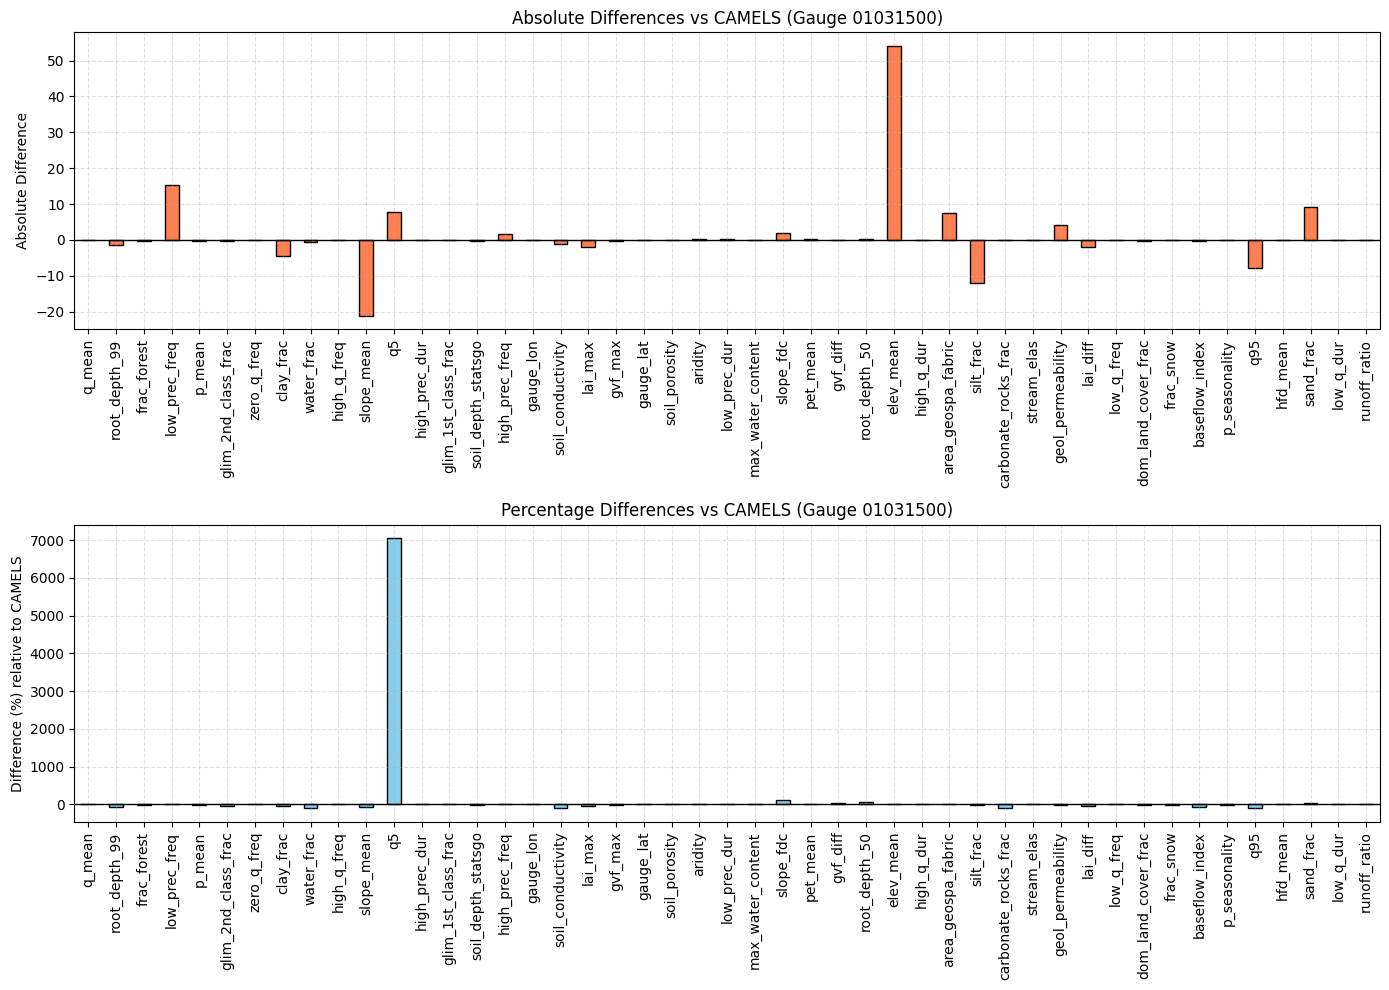

,CAMELS,Extracted,AbsDiff,PctDiff
elev_mean,247.800000,301.911682,5.411168e+01,2.183684e+01
low_prec_freq,227.350000,242.689922,1.533992e+01,6.747271e+00
sand_frac,35.269030,44.527933,9.258903e+00,2.625222e+01
q5,0.111345,7.957681,7.846336e+00,7.046783e+03
area_geospa_fabric,766.530000,774.153569,7.623569e+00,9.945558e-01
geol_permeability,-14.841000,-10.605812,4.235188e+00,-2.853708e+01
slope_fdc,1.494019,3.347549,1.853530e+00,1.240633e+02
high_prec_freq,18.900000,20.680822,1.780822e+00,9.422338e+00
pet_mean,2.071324,2.371978,3.006546e-01,1.451509e+01
low_prec_dur,3.473644,3.635261,1.616165e-01,4.652649e+00


In [22]:
from pygeohydro import get_camels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Load CAMELS dataset
camels_gdf, camels_ds = get_camels()

# Step 2: Normalize gauge_id (make it a column for convenience)
camels_gdf = camels_gdf.copy()
camels_gdf["gauge_id"] = camels_gdf.index.astype(str)

# Step 3: Check if current gauge is in CAMELS
if gauge_id in camels_gdf.index:
    print(f"✓ Gauge {gauge_id} found in CAMELS dataset.")

    # Step 4: Get the CAMELS attribute row
    camels_row = camels_gdf.loc[gauge_id]

    # Step 5: Get our extracted attributes
    if "final_df" in locals():
        our_row = final_df[final_df["gauge_id"] == gauge_id].iloc[0]
    else:
        raise ValueError("`final_df` not found in namespace. Ensure your data is loaded.")

    # Step 6: Select common numeric attributes
    common_cols = list(set(camels_row.index).intersection(set(our_row.index)))
    numeric_cols = [
        col for col in common_cols
        if pd.api.types.is_number(camels_row[col]) and pd.api.types.is_number(our_row[col])
    ]

    # Align series to the same order
    camels_vals = camels_row[numeric_cols].astype(float).reindex(numeric_cols)
    our_vals = our_row[numeric_cols].astype(float).reindex(numeric_cols)

    # Step 7: Compute absolute and percentage differences
    epsilon = 1e-6  # avoid divide-by-zero
    diff_abs = (our_vals.values - camels_vals.values).astype(float)
    diff_pct = ((our_vals.values - camels_vals.values) / (camels_vals.values + epsilon)) * 100

    # Step 8: Create stacked plots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Absolute difference plot
    pd.Series(diff_abs, index=numeric_cols).plot(
        kind="bar", ax=axes[0], color="coral", edgecolor="black"
    )
    axes[0].set_ylabel("Absolute Difference")
    axes[0].set_title(f"Absolute Differences vs CAMELS (Gauge {gauge_id})")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].axhline(0, color="black", linewidth=1)
    axes[0].tick_params(axis="x", rotation=90)

    # Percent difference plot
    pd.Series(diff_pct, index=numeric_cols).plot(
        kind="bar", ax=axes[1], color="skyblue", edgecolor="black"
    )
    axes[1].set_ylabel("Difference (%) relative to CAMELS")
    axes[1].set_title(f"Percentage Differences vs CAMELS (Gauge {gauge_id})")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].axhline(0, color="black", linewidth=1)
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

    # Optional: Print values side by side
    comparison_df = pd.DataFrame({
        "CAMELS": camels_vals.values,
        "Extracted": our_vals.values,
        "AbsDiff": diff_abs,
        "PctDiff": diff_pct
    }, index=numeric_cols).sort_values("AbsDiff", ascending=False)

    display(comparison_df)

else:
    print(f"✗ Gauge {gauge_id} not found in CAMELS dataset. Skipping comparison.")


## <span style="color:green">13. Extending to Multiple Basins</span>

### <span style="color:green">Learning Objectives</span>
- Scale the workflow to process multiple basins  
- Implement batch processing and error handling  
- Manage computational resources efficiently  

### <span style="color:green">Batch Processing Framework</span>
<p style='text-align: justify;'>
To move from a single-basin prototype to a <b>large-sample hydrology workflow</b>, we must extend the pipeline to handle multiple basins. 
This is achieved through <b>batch processing</b>, where each gauge is processed in sequence (or parallelized) with robust error handling and logging. 
Successful results are aggregated into a <b>combined CAMELS-like dataset</b>, while failures are tracked for troubleshooting. 
The framework also generates <b>summary statistics</b> and <b>correlation diagnostics</b> to provide insights into dataset completeness and attribute consistency across basins.
</p>

<p style='text-align: justify;'>
Key features of the batch processing framework include:  
- Automated watershed delineation and attribute extraction for each gauge  
- Integration of results into both <b>individual basin files</b> and a <b>national-scale combined dataset</b>  
- Export of summary statistics (attribute ranges, correlations, completeness)  
- Scalable design, with potential for <b>parallel or distributed execution</b> on HPC or cloud environments  
</p>

<p style='text-align: justify;'>
This framework ensures reproducibility, scalability, and efficiency, enabling the creation of CAMELS-like datasets for hundreds or thousands of basins simultaneously.
</p>


DEMONSTRATION: Batch Processing Multiple Basins
This example shows how to process multiple basins.
For a full implementation, you would:
1. Provide a comprehensive list of USGS gauge IDs
2. Set up proper error handling and logging
3. Consider computational resources and processing time
4. Implement resumption capabilities for long runs

Starting batch processing for 5 basins...
Output directory: outputs/batch_processing

Processing basin 1/5: 01054200
Delineating watershed for gauge 01054200...
✓ Successfully delineated watershed
  Gauge Name: Wild River At Gilead, Maine
  Area: 181.18 km²
  HUC02: 01
  Location: (44.391, -70.980)


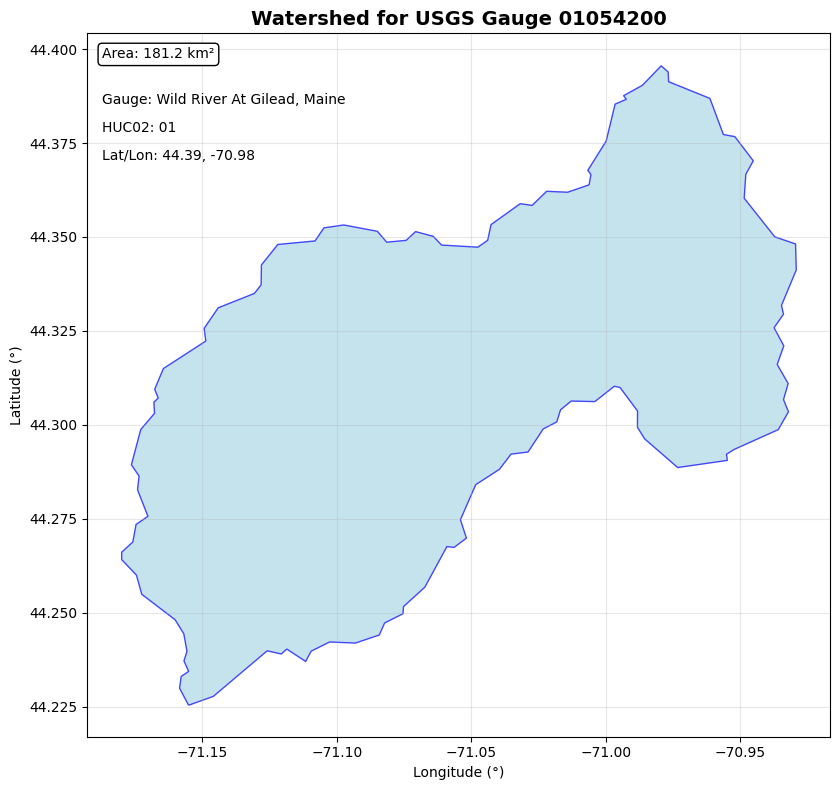

  Extracting topographic attributes...
Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.02, max=175.59, mean=26.27
✓ Topographic attributes extracted successfully
  Extracting climate attributes...
Fetching climate data from GridMET...
✓ Retrieved 4015 days of climate data
Computing climate indices...
✓ Climate indices computed successfully
  Extracting soil attributes...
Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully
  Extracting vegetation attributes...
Extracting vegetation attributes...
  - Fetching NLCD 2021 land cover...
✓ Vegeta

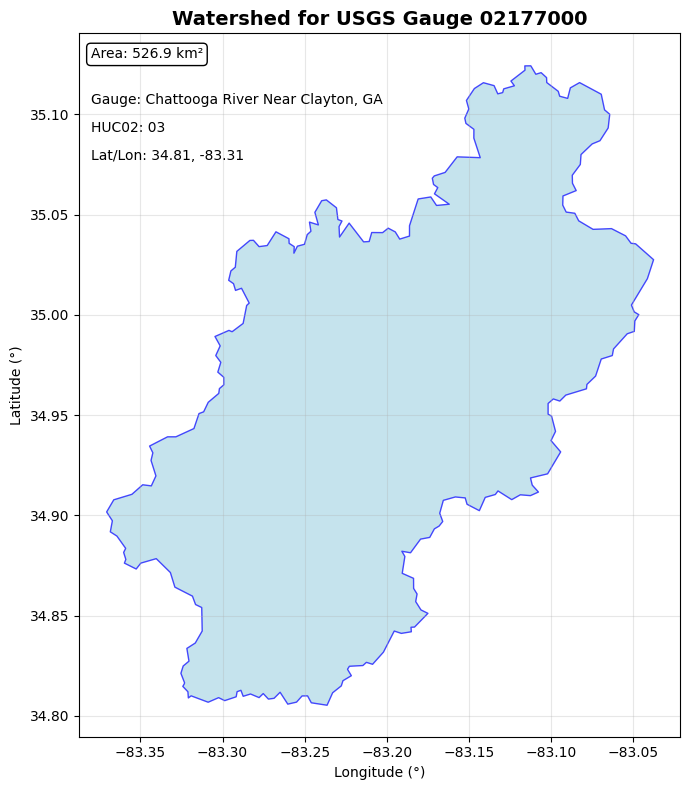

  Extracting topographic attributes...
Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.00, max=359.04, mean=29.64
✓ Topographic attributes extracted successfully
  Extracting climate attributes...
Fetching climate data from GridMET...
✓ Retrieved 4015 days of climate data
Computing climate indices...
✓ Climate indices computed successfully
  Extracting soil attributes...
Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully
  Extracting vegetation attributes...
Extracting vegetation attributes...
  - Fetching NLCD 2021 land cover...
✓ Vegeta

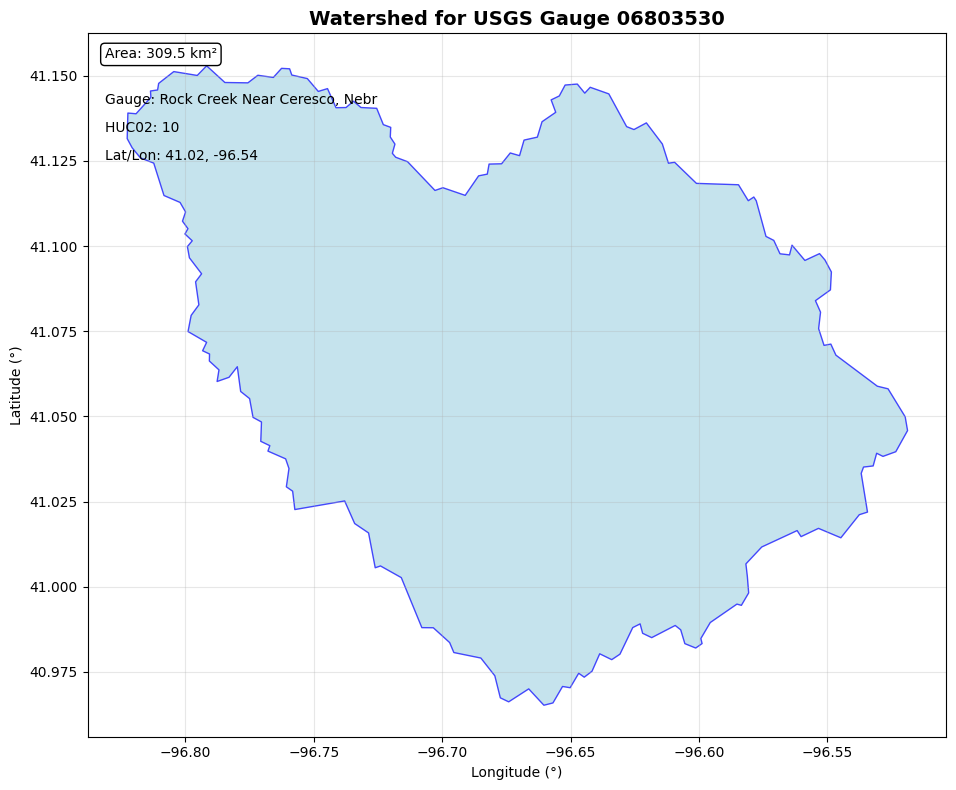

  Extracting topographic attributes...
Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.00, max=39.49, mean=5.08
✓ Topographic attributes extracted successfully
  Extracting climate attributes...
Fetching climate data from GridMET...
✓ Retrieved 4015 days of climate data
Computing climate indices...
✓ Climate indices computed successfully
  Extracting soil attributes...
Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully
  Extracting vegetation attributes...
Extracting vegetation attributes...
  - Fetching NLCD 2021 land cover...
✓ Vegetati

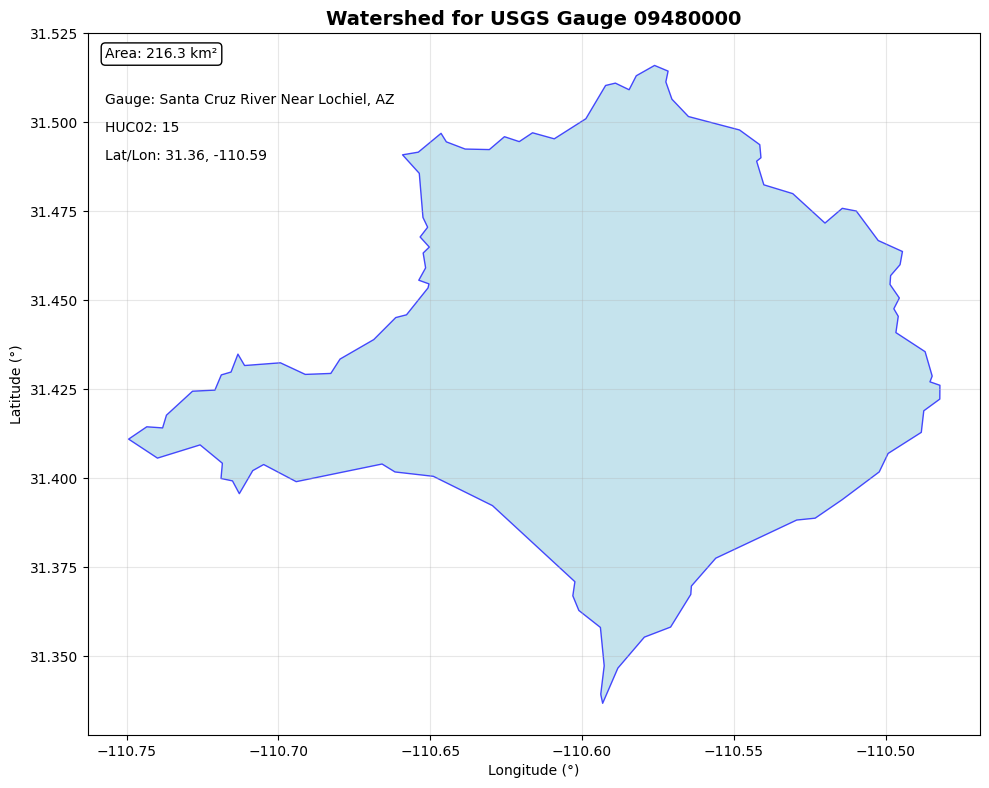

  Extracting topographic attributes...
Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.01, max=85.36, mean=9.80
✓ Topographic attributes extracted successfully
  Extracting climate attributes...
Fetching climate data from GridMET...
✓ Retrieved 4015 days of climate data
Computing climate indices...
✓ Climate indices computed successfully
  Extracting soil attributes...
Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully
  Extracting vegetation attributes...
Extracting vegetation attributes...
  - Fetching NLCD 2021 land cover...
✓ Vegetati

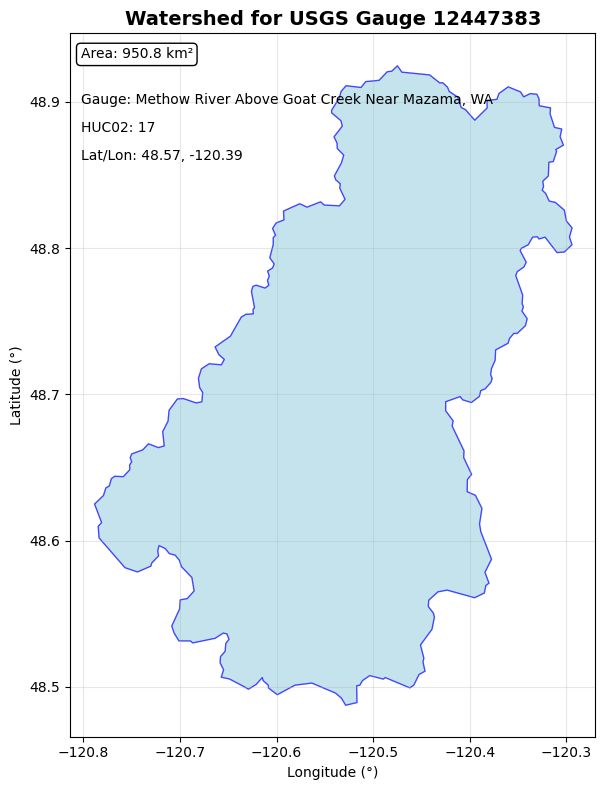

  Extracting topographic attributes...
Extracting topographic attributes...
  - Downloading DEM data...
  - Computing slope...
  - Slope stats (%):
    min=0.00, max=552.34, mean=55.55
✓ Topographic attributes extracted successfully
  Extracting climate attributes...
Fetching climate data from GridMET...
✓ Retrieved 4015 days of climate data
Computing climate indices...
✓ Climate indices computed successfully
  Extracting soil attributes...
Extracting soil attributes...
  ✓ Porosity extracted
  ✓ AWC extracted
  ✓ Field Capacity extracted
  - Downloading POLARIS texture + ksat (sand, silt, clay, ksat @ depths 5,15,30)...
    ✓ Texture fractions extracted using 3 depth layers
    ✓ Soil conductivity extracted from POLARIS (m/s)
    ✓ Converted soil conductivity to log10(mm/h)
  ✓ Thickness extracted
  ✓ Storage capacity computed
✓ Soil attributes extracted successfully
  Extracting vegetation attributes...
Extracting vegetation attributes...
  - Fetching NLCD 2021 land cover...
✓ Vegeta

In [42]:
def process_multiple_basins(gauge_list, output_dir="outputs/batch_processing"):
    """
    Process multiple basins using the CAMELS-like extraction workflow
    
    """
    import os
    import json
    from datetime import datetime
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f"{output_dir}/individual_basins", exist_ok=True)
    os.makedirs(f"{output_dir}/combined_datasets", exist_ok=True)
    os.makedirs(f"{output_dir}/processing_logs", exist_ok=True)
    
    print(f"Starting batch processing for {len(gauge_list)} basins...")
    print(f"Output directory: {output_dir}")
    
    # Initialize tracking
    results_summary = {
        'total_basins': len(gauge_list),
        'successful': [],
        'failed': [],
        'processing_start': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'processing_end': None,
        'individual_results': {}
    }
    
    all_basin_data = []
    
    # ------------------------------
    # Safe serialization helper
    # ------------------------------
    def safe_serialize(obj, gauge_id=None):
        """Convert non-serializable objects for JSON export."""
        import pandas as pd
        if isinstance(obj, pd.DataFrame):
            # Save DataFrame to CSV instead of bloating JSON
            if gauge_id:
                csv_path = f"{output_dir}/individual_basins/{gauge_id}_data.csv"
                obj.to_csv(csv_path, index=False)
                return {"dataframe_saved": csv_path, "rows": len(obj), "cols": list(obj.columns)}
            return obj.to_dict(orient="records")
        elif isinstance(obj, pd.Series):
            return obj.to_dict()
        elif isinstance(obj, (set,)):
            return list(obj)
        else:
            return obj
    
    # Process each basin
    for i, gauge_id in enumerate(gauge_list):
        print(f"\n{'='*60}")
        print(f"Processing basin {i+1}/{len(gauge_list)}: {gauge_id}")
        print(f"{'='*60}")
        
        try:
            # Process single basin
            basin_result = process_single_basin_batch(gauge_id, output_dir)
            
            # Handle success/failure
            if basin_result['success']:
                results_summary['successful'].append(gauge_id)
                all_basin_data.append(basin_result['data'])
                print(f"✓ Successfully processed gauge {gauge_id}")
            else:
                results_summary['failed'].append(gauge_id)
                print(f"✗ Failed to process gauge {gauge_id}: {basin_result['error']}")
            
            # Store sanitized results
            results_summary['individual_results'][gauge_id] = {
                k: safe_serialize(v, gauge_id) for k, v in basin_result.items()
            }
        
        except Exception as e:
            print(f"✗ Unexpected error processing gauge {gauge_id}: {str(e)}")
            results_summary['failed'].append(gauge_id)
            results_summary['individual_results'][gauge_id] = {
                'success': False,
                'error': str(e),
                'data': None
            }
    
    # Create combined dataset if possible
    if all_basin_data:
        print(f"\nCreating combined dataset for {len(all_basin_data)} successful basins...")
        combined_df = pd.concat(all_basin_data, ignore_index=True)
        
        # Export combined dataset
        combined_path = f"{output_dir}/combined_datasets/camels_like_dataset.csv"
        combined_df.to_csv(combined_path, index=False)
        print(f"✓ Combined dataset saved: {combined_path}")
        
        # Create summary statistics
        create_batch_summary_stats(combined_df, output_dir)
        
        # Add reference only (not whole DataFrame!)
        results_summary['combined_dataset'] = combined_path
    
    # Finalize results
    results_summary['processing_end'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    results_summary['success_rate'] = len(results_summary['successful']) / len(gauge_list)
    
    # Save processing summary (JSON safe now)
    summary_path = f"{output_dir}/processing_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\n{'='*60}")
    print("BATCH PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Total basins processed: {len(gauge_list)}")
    print(f"Successful: {len(results_summary['successful'])} ({results_summary['success_rate']:.1%})")
    print(f"Failed: {len(results_summary['failed'])}")
    print(f"Results saved to: {output_dir}")
    
    return results_summary

def process_single_basin_batch(gauge_id, output_dir):
    """
    Process a single basin in batch mode with error handling
    
    """
    result = {
        'gauge_id': gauge_id,
        'success': False,
        'error': None,
        'data': None,
        'processing_time': None,
        'attributes_extracted': 0
    }
    
    start_time = datetime.now()
    
    try:
        # 1. Watershed delineation
        watershed_gdf, watershed_geom, metadata, area_km2 = delineate_watershed(gauge_id, save_shapefile=False)
        if watershed_gdf is None:
            raise Exception("Failed to delineate watershed")
        
        # 2. Extract all attributes with error handling
        print("  Extracting topographic attributes...")
        topo_attrs, _, _,_ = extract_topographic_attributes(watershed_geom)
        if topo_attrs is None:
            topo_attrs = {'elev_mean': np.nan, 'slope_mean': np.nan, 'area_geospa_fabric': np.nan}
        
        print("  Extracting climate attributes...")
        climate_ds = fetch_climate_data(watershed_geom, start_date="2010-01-01", end_date="2020-12-31")
        if climate_ds is not None:
            climate_attrs = compute_climate_indices(climate_ds)
        else:
            climate_attrs = {'p_mean': np.nan, 'pet_mean': np.nan, 'aridity': np.nan}
        
        print("  Extracting soil attributes...")
        soil_attrs = extract_soil_attributes(watershed_geom)
        
        print("  Extracting vegetation attributes...")
        veg_attrs = extract_vegetation_attributes(watershed_geom,gauge_id)
        
        print("  Extracting geological attributes...")
        geol_attrs = extract_geological_attributes(watershed_gdf)
        
        print("  Extracting hydrological signatures...")
        hydro_attrs = extract_hydrological_signatures(gauge_id, watershed_geom, 
                                                     start_date="2010-01-01", end_date="2020-12-31")
        
        # 3. Integrate attributes
        
        basin_df, _ = integrate_all_attributes(
        gauge_id,
        topo_attrs,
        climate_attrs[0],   # take dict out of tuple
        soil_attrs[0],
        veg_attrs,
        geol_attrs[0],
        hydro_attrs,
        metadata=metadata
        )

        
        if basin_df is None:
            raise Exception("Failed to integrate attributes")
        
        # 4. Save individual basin results
        individual_dir = f"{output_dir}/individual_basins/{gauge_id}"
        os.makedirs(individual_dir, exist_ok=True)
        
        basin_path = f"{individual_dir}/attributes_{gauge_id}.csv"
        basin_df.to_csv(basin_path, index=False)
        
        # 5. Update result
        result['success'] = True
        result['data'] = basin_df
        result['attributes_extracted'] = len(basin_df.columns)
        result['processing_time'] = (datetime.now() - start_time).total_seconds()
        
    except Exception as e:
        result['error'] = str(e)
        result['processing_time'] = (datetime.now() - start_time).total_seconds()
    
    return result

def create_batch_summary_stats(combined_df, output_dir):
    """Create summary statistics for the batch processing results"""
    
    # Basic statistics
    stats_summary = {
        'total_basins': len(combined_df),
        'total_attributes': len(combined_df.columns),
        'data_completeness': (combined_df.notna().sum() / len(combined_df)).to_dict(),
        'attribute_ranges': {},
        'correlations': {}
    }
    
    # Calculate ranges for numerical attributes
    numerical_cols = combined_df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if col in combined_df.columns:
            stats_summary['attribute_ranges'][col] = {
                'min': float(combined_df[col].min()),
                'max': float(combined_df[col].max()),
                'mean': float(combined_df[col].mean()),
                'std': float(combined_df[col].std())
            }
    
    # Save summary statistics
    stats_path = f"{output_dir}/combined_datasets/summary_statistics.json"
    with open(stats_path, 'w') as f:
        json.dump(stats_summary, f, indent=2)
    
    # Create correlation matrix for key attributes
    key_attrs = ['elev_mean', 'slope_mean', 'p_mean', 'aridity', 'runoff_ratio', 
                'q_mean', 'baseflow_index']
    available_attrs = [attr for attr in key_attrs if attr in combined_df.columns]
    
    if len(available_attrs) > 3:
        corr_matrix = combined_df[available_attrs].corr()
        
        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
        plt.colorbar(label='Correlation Coefficient')
        plt.xticks(range(len(available_attrs)), available_attrs, rotation=45)
        plt.yticks(range(len(available_attrs)), available_attrs)
        plt.title('Correlation Matrix of Key Attributes')
        
        # Add correlation values
        for i in range(len(available_attrs)):
            for j in range(len(available_attrs)):
                plt.text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', 
                        ha='center', va='center')
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/combined_datasets/correlation_matrix.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"✓ Summary statistics created for {len(combined_df)} basins")

# ================================
# Batch Processing Entry Point
# ================================

if __name__ == "__main__":
    # Example: replace with your full list of USGS gauge IDs
    gauge_list = [
        "01054200",  # Maine
        "02177000",  # South Carolina
        "06803530",  # Nebraska
        "09480000",  # Arizona
        "12447383"   # Washington
    ]

    # Run batch processing
    results = process_multiple_basins(gauge_list)

    # Print a short summary
    print("\nBatch run finished.")
    print(f"Total: {results['total_basins']}, "
          f"Successful: {len(results['successful'])}, "
          f"Failed: {len(results['failed'])}")


## <span style="color:green">14. Summary </span>

### Key Achievements
In this tutorial, we:
1. Replicated **CAMELS methodology** for any USGS basin  
2. Integrated **multiple open datasets** (topography, climate, soils, vegetation, geology, hydrology)  
3. Computed a **comprehensive attribute set** for catchment analysis  
4. Implemented **validation**  
5. Demonstrated **scalability** to large-sample hydrology  

### References
- Newman et al. (2015), Addor et al. (2017) – Original CAMELS dataset  
- USGS 3DEP, GridMET, gNATSGO, MODIS, GLiM, GLHYMPS – Data sources  
- HyRiver ecosystem, Planetary Computer SDK, GeoPandas – Core tools  

---

<p style='text-align: justify;'>
This framework makes CAMELS-like datasets reproducible, scalable, and aligned with FAIR principles. It enables both single-basin studies and national-scale hydrology, supporting open science and next-generation hydrological modeling.
</p>

*For questions or issues, contact: mgalib@purdue.edu or vmerwade@purdue.edu*

# CAMELS Attributes Table

This document lists the attribute groups and their descriptions, units, data sources, and references for the original CAMELS dataset.

---

## camels_name – Name
| Attribute  | Description | Unit | Data source | References |
|------------|-------------|------|-------------|------------|
| gauge_id   | catchment identifier (8-digit USGS hydrologic unit code) | - | N15 – USGS data | |
| huc_02     | region (2-digit USGS hydrologic unit code) | - | N15 – USGS data | |
| gauge_name | gauge name, followed by the state | - | N15 – USGS data | |

---

## camels_topo – Topography and location
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| gauge_lat | gauge latitude | ° north | N15 – USGS data | |
| gauge_lon | gauge longitude | ° east | N15 – USGS data | |
| elev_mean | catchment mean elevation | m above sea level | N15 – USGS data | |
| slope_mean | catchment mean slope | m/km | N15 – USGS data | |
| area_gages2 | catchment area (GAGESII estimate) | km² | N15 – USGS data | Falcone (2011) |
| area_geospa_fabric | catchment area (Geospatial Fabric estimate) | km² | N15 – Geospatial Fabric | Viger (2014); Viger & Bock (2014) |

---

## camels_clim – Climate indices (*1989/10/01–2009/09/30*)
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| p_mean | mean daily precipitation | mm/day | N15 – Daymet | |
| pet_mean | mean daily PET (Priestley-Taylor calibrated) | mm/day | N15 – Daymet | |
| aridity | aridity index (PET/P) | - | N15 – Daymet | |
| p_seasonality | precipitation seasonality & timing (sine curves, + = summer, – = winter) | - | N15 – Daymet | Woods et al. (2009), Eq. 14 |
| frac_snow_daily | fraction of precipitation falling as snow (T < 0°C) | - | N15 – Daymet | |
| high_prec_freq | frequency of high-precipitation days (≥ 5× mean daily P) | days/yr | N15 – Daymet | |
| high_prec_dur | average duration of high-precipitation events | days | N15 – Daymet | |
| high_prec_timing | season of most high-precipitation days | season | N15 – Daymet | |
| low_prec_freq | frequency of dry days (< 1 mm/day) | days/yr | N15 – Daymet | |
| low_prec_dur | average duration of dry periods | days | N15 – Daymet | |
| low_prec_timing | season of most dry days | season | N15 – Daymet | |

---

## camels_hydro – Hydrological signatures (*1989/10/01–2009/09/30*)
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| q_mean | mean daily discharge | mm/day | N15 – USGS data | |
| runoff_ratio | runoff ratio (Q/P) | - | N15 – USGS data | Sawicz et al. (2011), Eq. 2 |
| stream_elas | streamflow–precipitation elasticity | - | N15 – USGS data | Sankarasubramanian et al. (2001), Eq. 7 |
| slope_fdc | slope of flow duration curve (log Q33–Q66) | - | N15 – USGS data | Sawicz et al. (2011), Eq. 3 |
| baseflow_index | baseflow index (BF/Q, digital filter) | - | N15 – USGS data | Ladson et al. (2013) |
| hfd_mean | mean half-flow date (day of year) | DOY | N15 – USGS data | Court (1962) |
| Q5 | 5% flow quantile (low flow) | mm/day | N15 – USGS data | |
| Q95 | 95% flow quantile (high flow) | mm/day | N15 – USGS data | |
| high_q_freq | frequency of high-flow days (> 9× median flow) | days/yr | N15 – USGS data | Clausen & Biggs (2000); Westerberg & McMillan (2015) |
| high_q_dur | duration of high-flow events | days | N15 – USGS data | Clausen & Biggs (2000); Westerberg & McMillan (2015) |
| low_q_freq | frequency of low-flow days (< 0.2× mean flow) | days/yr | N15 – USGS data | Olden & Poff (2003); Westerberg & McMillan (2015) |
| low_q_dur | duration of low-flow events | days | N15 – USGS data | Olden & Poff (2003); Westerberg & McMillan (2015) |
| zero_q_freq | frequency of zero-flow days | % | N15 – USGS data | |

---

## camels_vege – Land cover characteristics (*2002–2014*)
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| forest_frac | forest fraction | - | N15 – USGS data | |
| lai_max | maximum monthly mean LAI | - | MODIS | |
| lai_diff | seasonal LAI difference (max–min) | - | MODIS | |
| gvf_max | maximum monthly mean green vegetation fraction | - | MODIS | |
| gvf_diff | seasonal GVF difference (max–min) | - | MODIS | |
| dom_land_cover | dominant land cover type (20-class IGBP-MODIS) | - | MODIS | |
| dom_land_cover_frac | fraction of area under dominant land cover | - | MODIS | |
| root_depth_XX | root depth (percentiles 50%, 99%) | m | MODIS | Zeng (2001), Eq. 2, Table 2 |

---

## camels_soil – Soil characteristics (*top 1.5 m*)
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| soil_depth_pelletier | depth to bedrock (max 50 m) | m | Pelletier et al. (2016) | |
| soil_depth_statgso | soil depth (max 1.5 m) | m | STATSGO | Miller & White (1998) |
| soil_porosity | volumetric porosity (saturated water content) | - | STATSGO | Cosby et al. (1984); Lawrence & Slater (2008) |
| soil_conductivity | saturated hydraulic conductivity | cm/hr | STATSGO | Cosby et al. (1984); Lawrence & Slater (2008) |
| max_water_content | maximum water content (porosity × depth) | m | STATSGO | |
| sand_frac | sand fraction (< 2 mm) | % | STATSGO | |
| silt_frac | silt fraction (< 2 mm) | % | STATSGO | |
| clay_frac | clay fraction (< 2 mm) | % | STATSGO | |
| water_frac | fraction marked as water (class 14) | % | STATSGO | |
| organic_frac | fraction marked as organic material (class 13) | % | STATSGO | |
| other_frac | fraction marked as “other” (class 16) | % | STATSGO | |

---

## camels_geol – Geological characteristics
| Attribute | Description | Unit | Data source | References |
|-----------|-------------|------|-------------|------------|
| geol_class_1st | most common geologic class | - | GLiM | Hartmann & Moosdorf (2012) |
| geol_class_1st_frac | fraction of catchment in most common class | - | GLiM | Hartmann & Moosdorf (2012) |
| geol_class_2nd | 2nd most common geologic class | - | GLiM | Hartmann & Moosdorf (2012) |
| geol_class_2nd_frac | fraction of catchment in 2nd class | - | GLiM | Hartmann & Moosdorf (2012) |
| carb_rocks_frac | fraction of carbonate sedimentary rocks | - | GLiM | Hartmann & Moosdorf (2012) |
| geol_porosity | subsurface porosity | - | GLHYMPS | Gleeson et al. (2014) |
| geol_permeability | subsurface permeability (log10) | m² | GLHYMPS | Gleeson et al. (2014) |


| Attribute  | Description | Unit | Data source | References |
|------------|-------------|------|-------------|------------|
| gauge_id   | catchment identifier | - | USGS | |
| huc_02     | region code | - | USGS | |
| gauge_name | gauge name | - | USGS | |
